# 情绪因子

我们的基本情绪因子库如下:

In [1]:
# coding=utf-8
import time
import sys
import os
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")

from IPython.display import display
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib.pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.dates as mdate
from tqdm import tqdm_notebook

pd.set_option("max_rows", None, "max_colwidth", 1000)
FactorInfo = pd.read_csv(".\\csv\\情绪因子.csv", header=0, index_col=0, encoding="utf-8")
display(FactorInfo)

,因子描述,排序方向,数据类型
因子名称,,,
EPS_FY0_R1M,一致预期 EPS_FY0 过去20天的变化率,降序,double
EPS_FY0_R3M,一致预期 EPS_FY0 过去60天的变化率,降序,double
EPS_Fwd12M_R1M,一致预期 EPS_未来12个月预测值过去20天的变化率,降序,double
EPS_Fwd12M_R3M,一致预期 EPS_未来12个月预测值过去60天的变化率,降序,double
ROE_FY0_R1M,一致预期 ROE_FY0 过去20天的变化率,降序,double
ROE_FY0_R3M,一致预期 ROE_FY0 过去60天的变化率,降序,double
ROE_Fwd12M_R1M,一致预期 ROE_未来12个月预测值过去20天的变化率,降序,double
ROE_Fwd12M_R3M,一致预期 ROE_未来12个月预测值过去60天的变化率,降序,double
Rating_R1M,分析师综合评级1个月的变化率,升序,double


说明：
* 后缀 FY0: 表示使用最近预测年度的分析师预期数据计算因子值，假设当前时点可见的最新年报是 2017 年年报, 则最近预测年度为 2018 年.
* 后缀 RnM: 表示使用过去多长的时间窗口(以月为单位)数据来计算因子值，比如 R1M 表示一个月(20 个交易日)

下面对情绪类因子进行 IC 和分位数组合测试其选股能力:

==========历史回测==========
1. 初始化耗时 : 0.03
2. 循环计算

100%|████████████████████████████████████████| 132/132 [07:03<00:00,  3.21s/it]


耗时 : 433.94
3. 结果生成耗时 : 11.19
总耗时 : 445.20


,平均值,标准差,最小值,最大值,IC_IR,t统计量,平均股票数,IC×Sqrt(N),有效期数
EPS_FY0_R1M,2.77%,4.91%,-10.98%,14.52%,0.5646,6.46,1440.28,1.05,131
EPS_FY0_R3M,2.57%,7.33%,-16.94%,20.94%,0.3501,4.01,1353.63,0.94,131
EPS_Fwd12M_R1M,2.24%,6.21%,-17.65%,15.38%,0.3602,4.12,1463.64,0.86,131
EPS_Fwd12M_R3M,3.25%,7.71%,-21.31%,22.48%,0.4221,4.83,1376.29,1.21,131
ROE_FY0_R1M,3.01%,4.77%,-8.42%,14.46%,0.6303,7.21,1390.44,1.12,131
ROE_FY0_R3M,2.49%,7.11%,-17.01%,18.61%,0.3499,4.01,1303.08,0.90,131
ROE_Fwd12M_R1M,1.91%,5.74%,-17.80%,14.72%,0.3322,3.80,1435.06,0.72,131
ROE_Fwd12M_R3M,2.61%,6.66%,-22.66%,16.31%,0.3916,4.48,1347.37,0.96,131
Rating,1.43%,9.68%,-22.69%,28.49%,0.1478,1.69,1585.25,0.57,131
Rating_R1M,1.34%,3.55%,-10.38%,11.77%,0.3784,4.33,1540.99,0.53,131

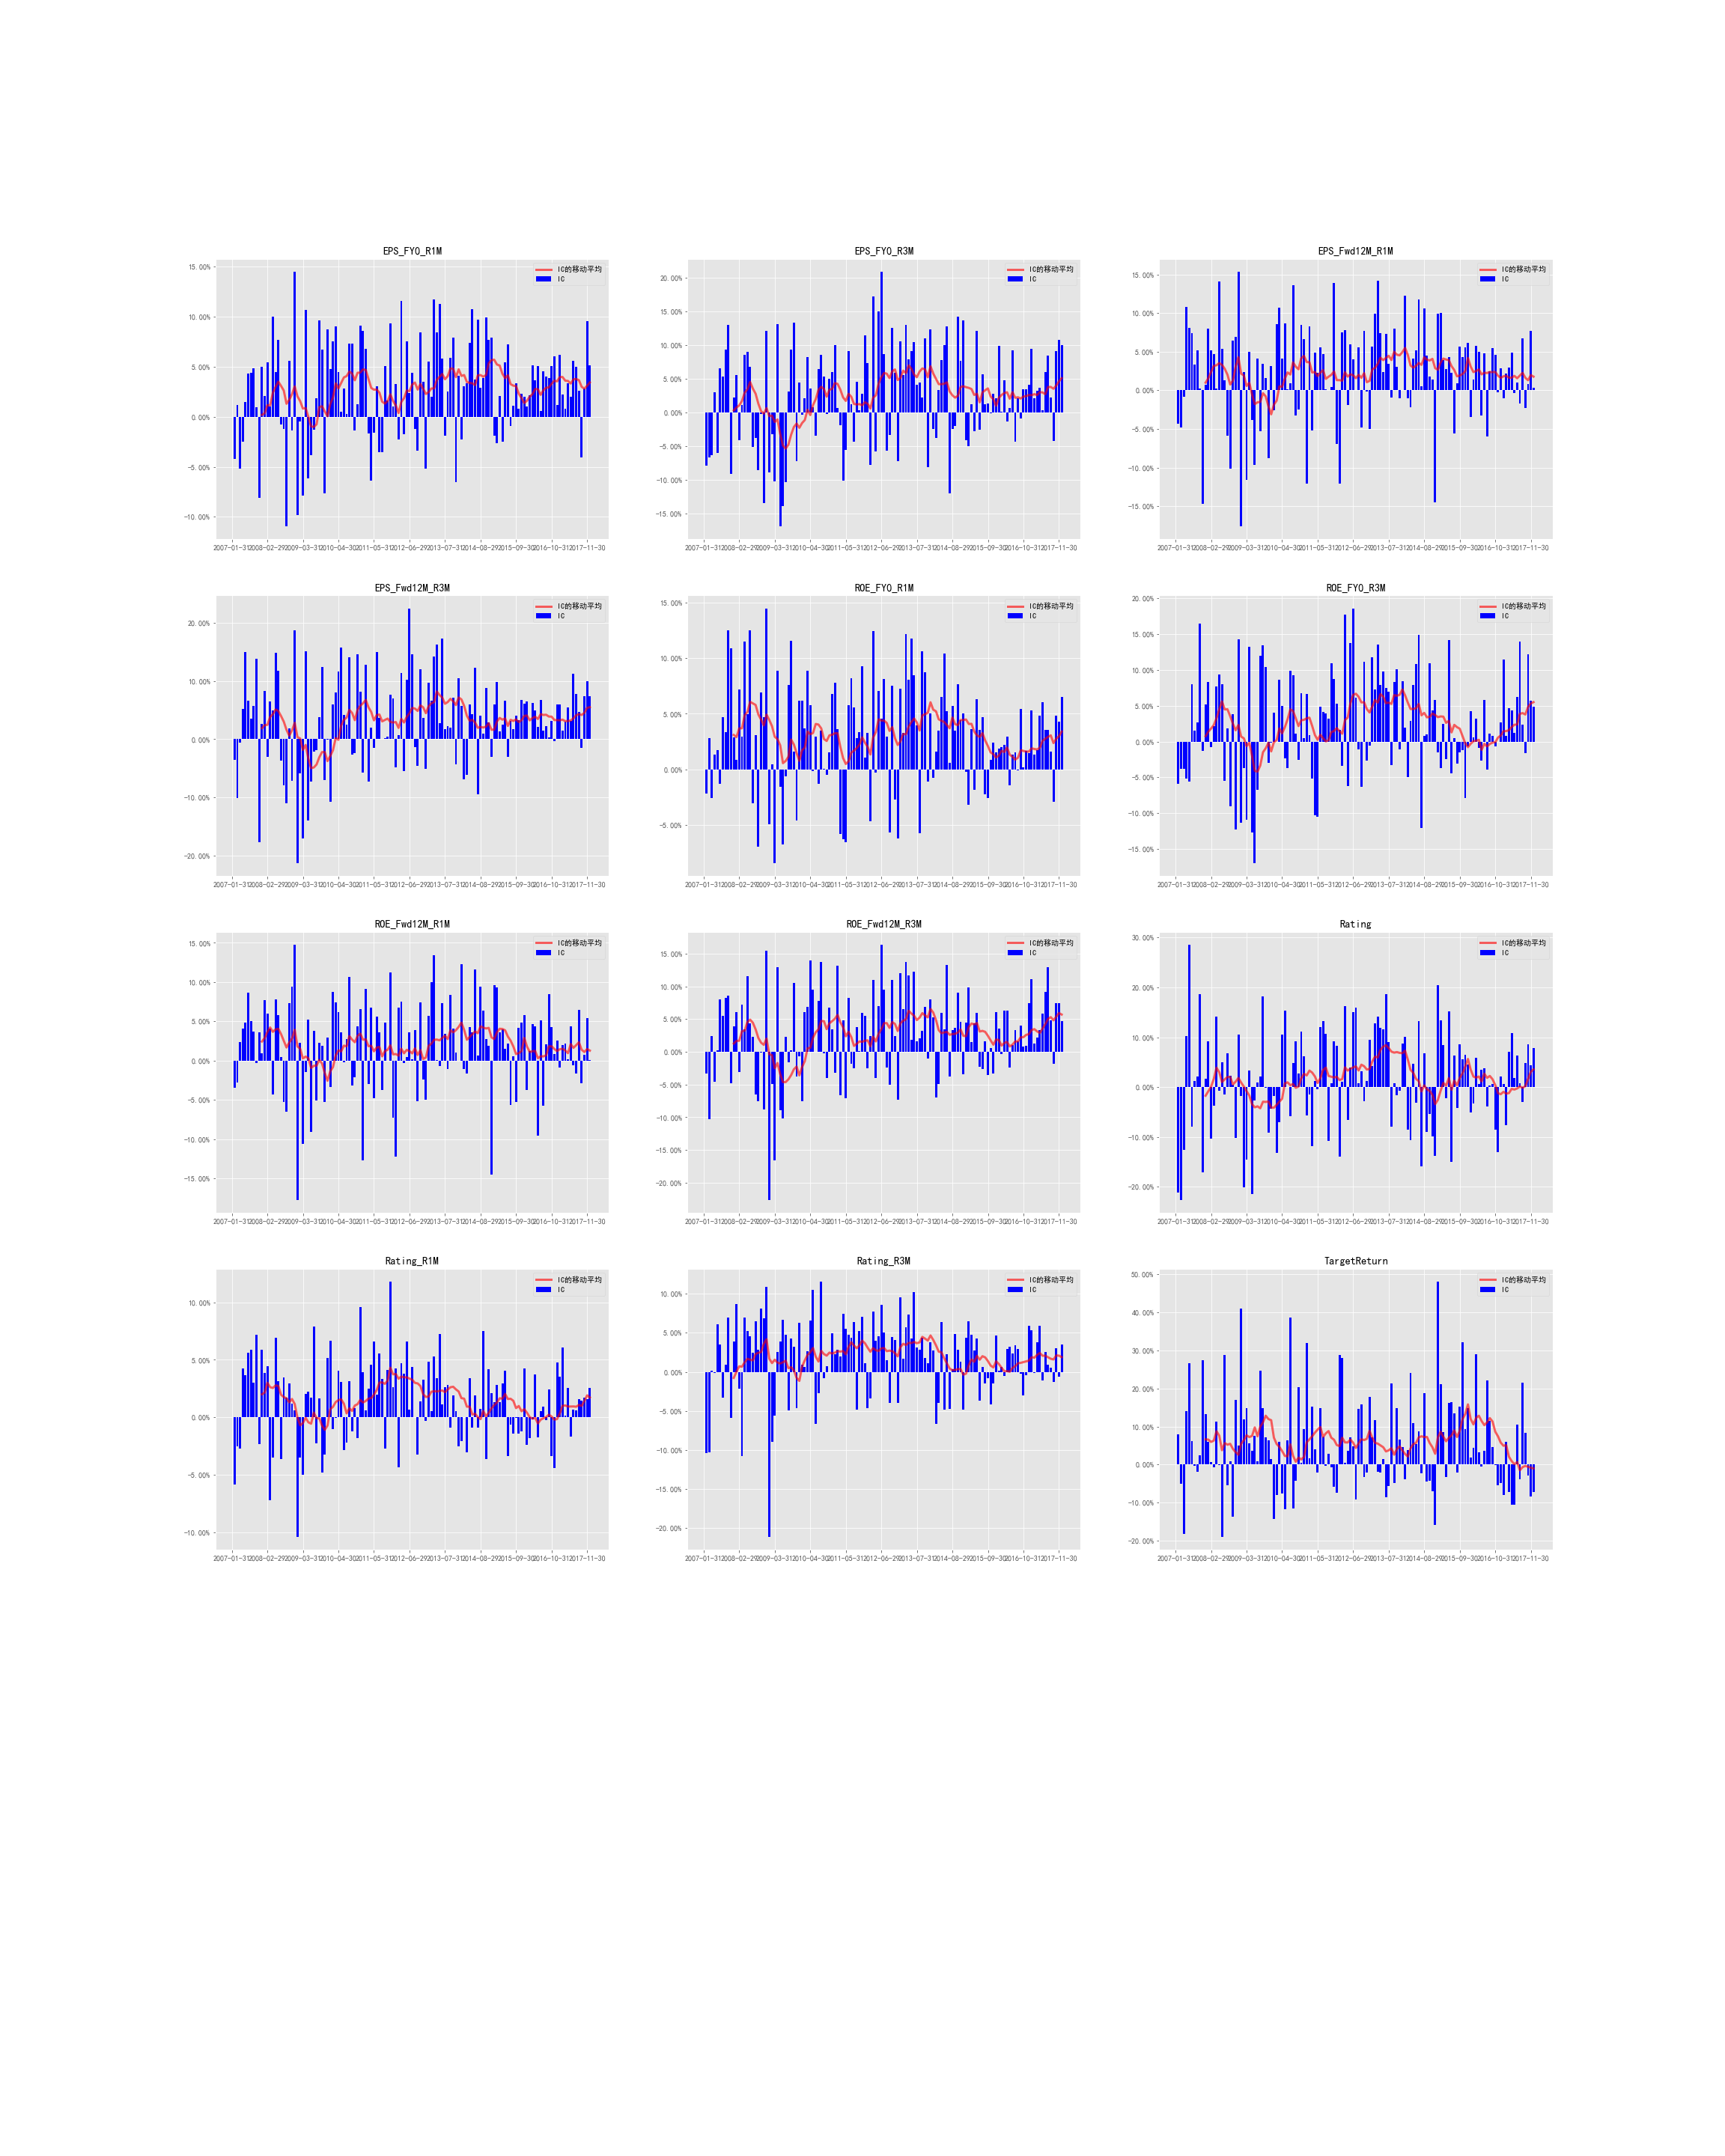
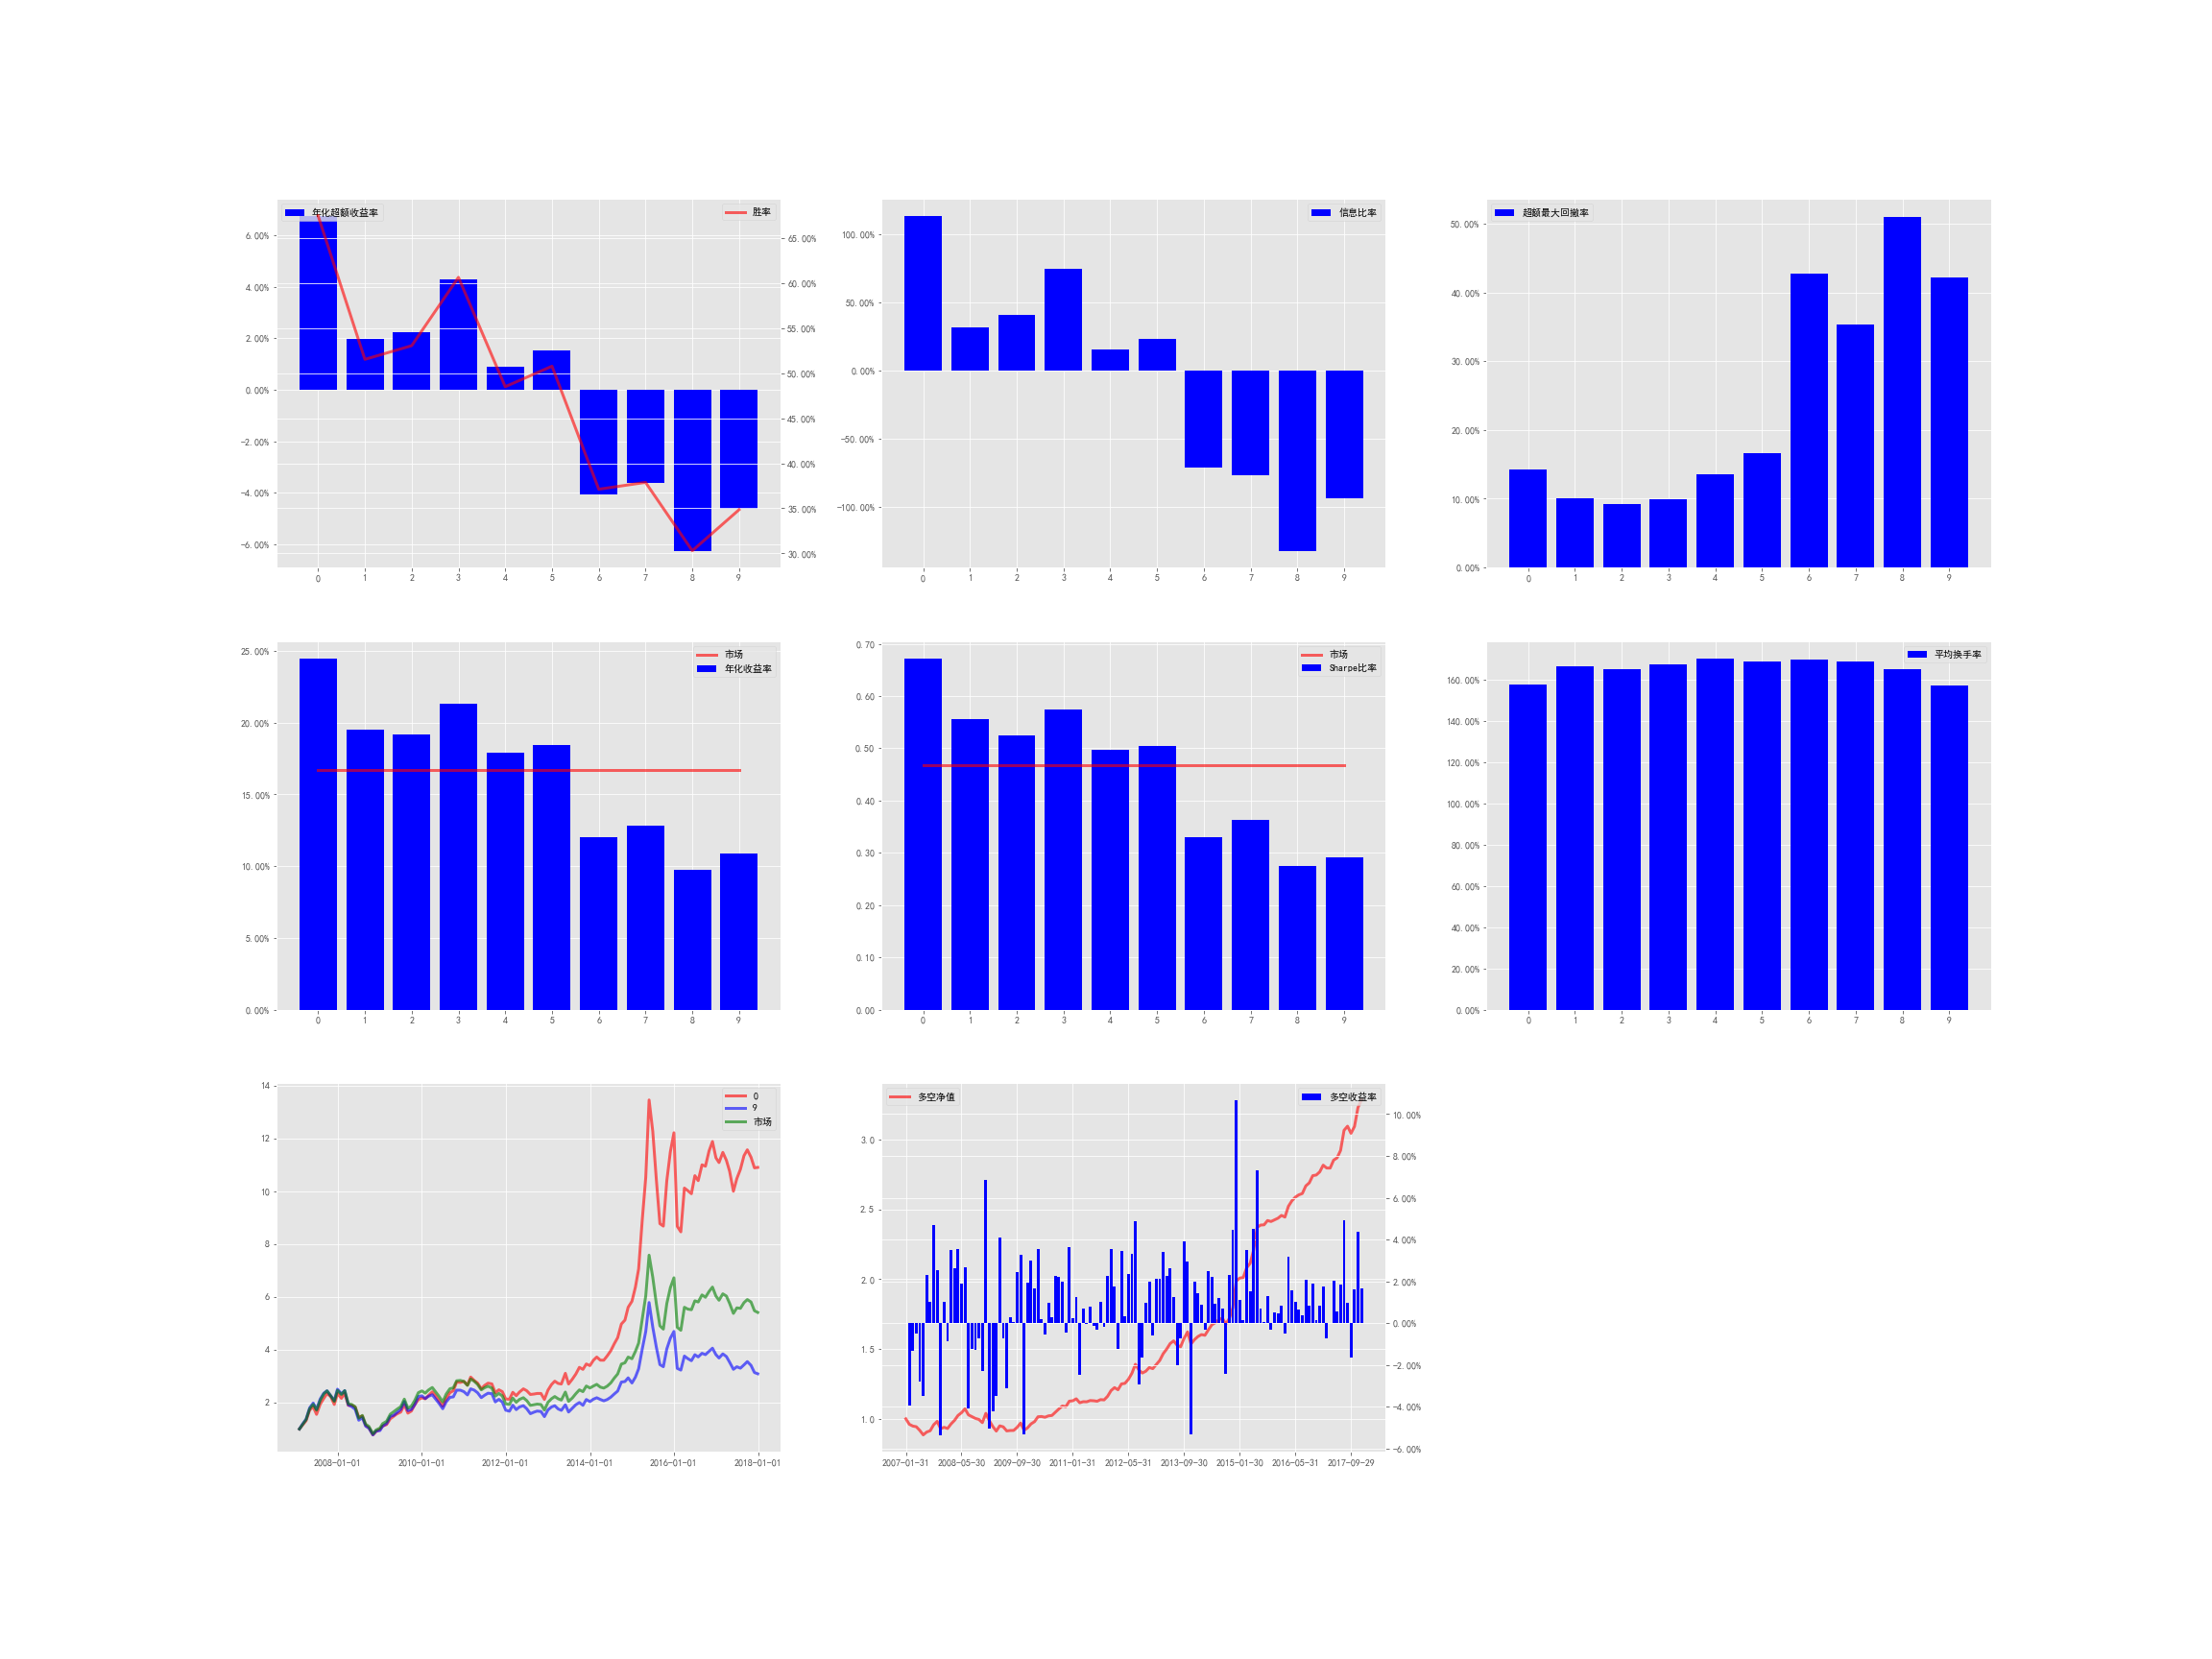
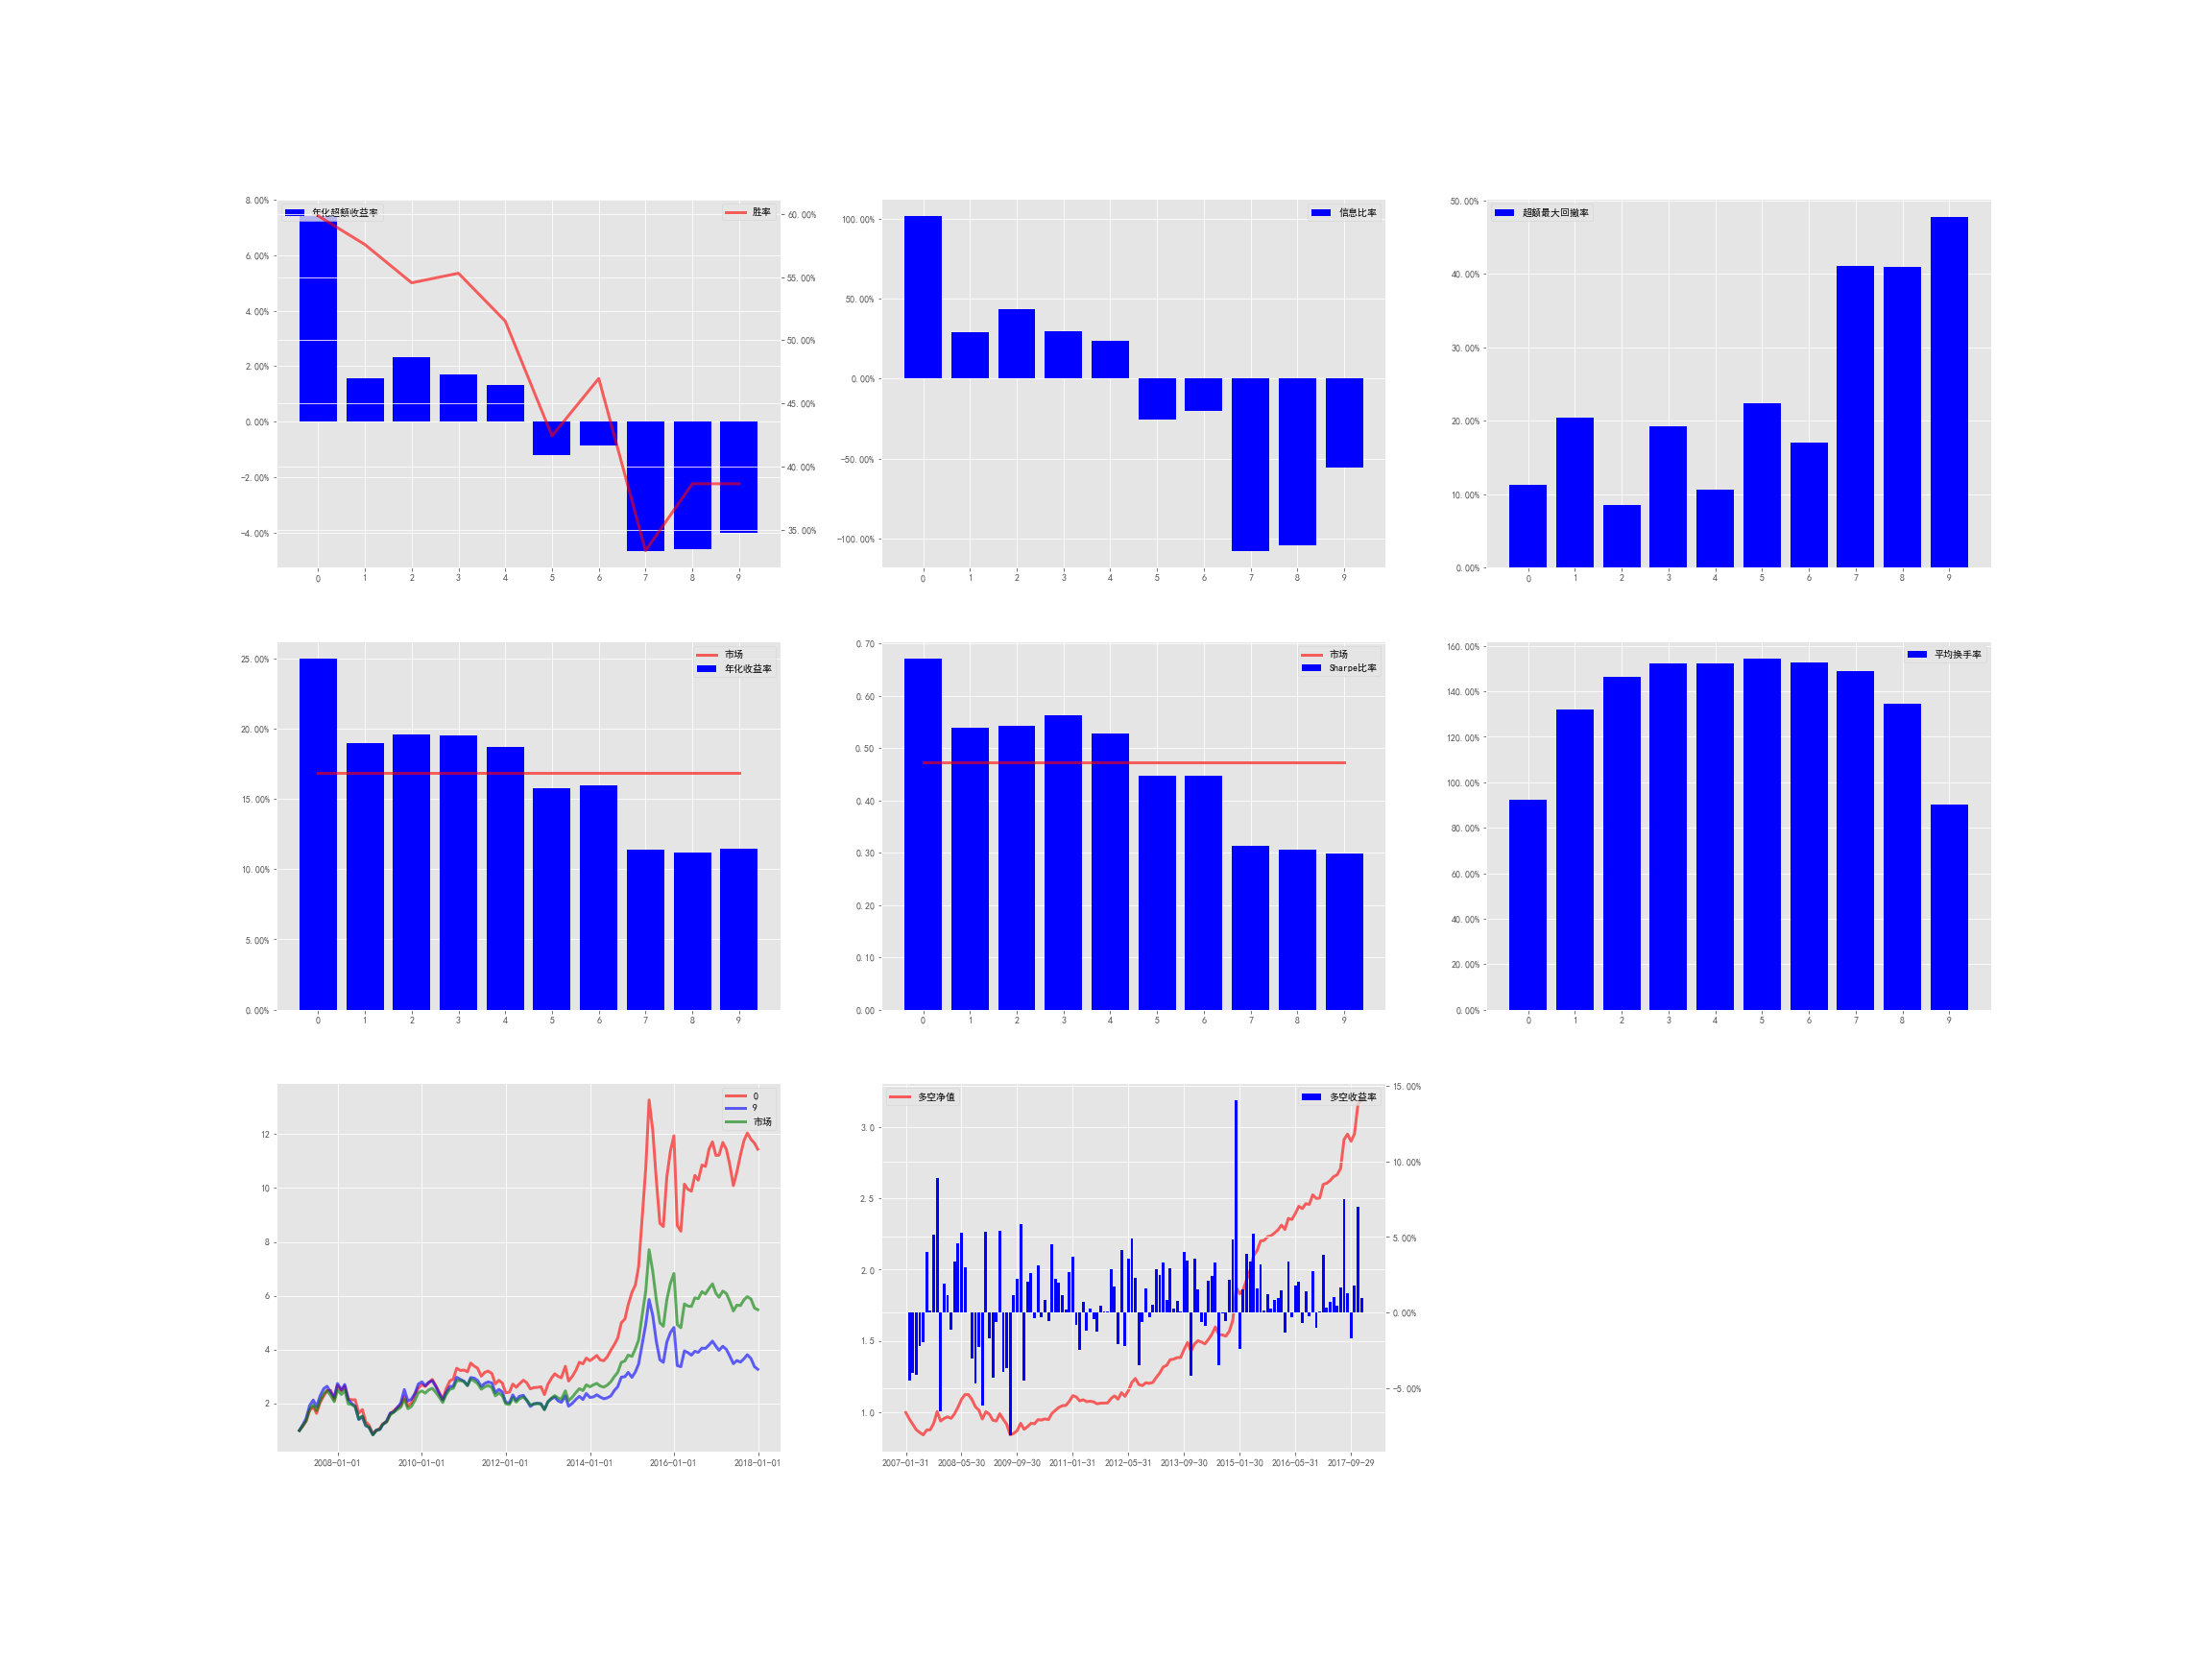
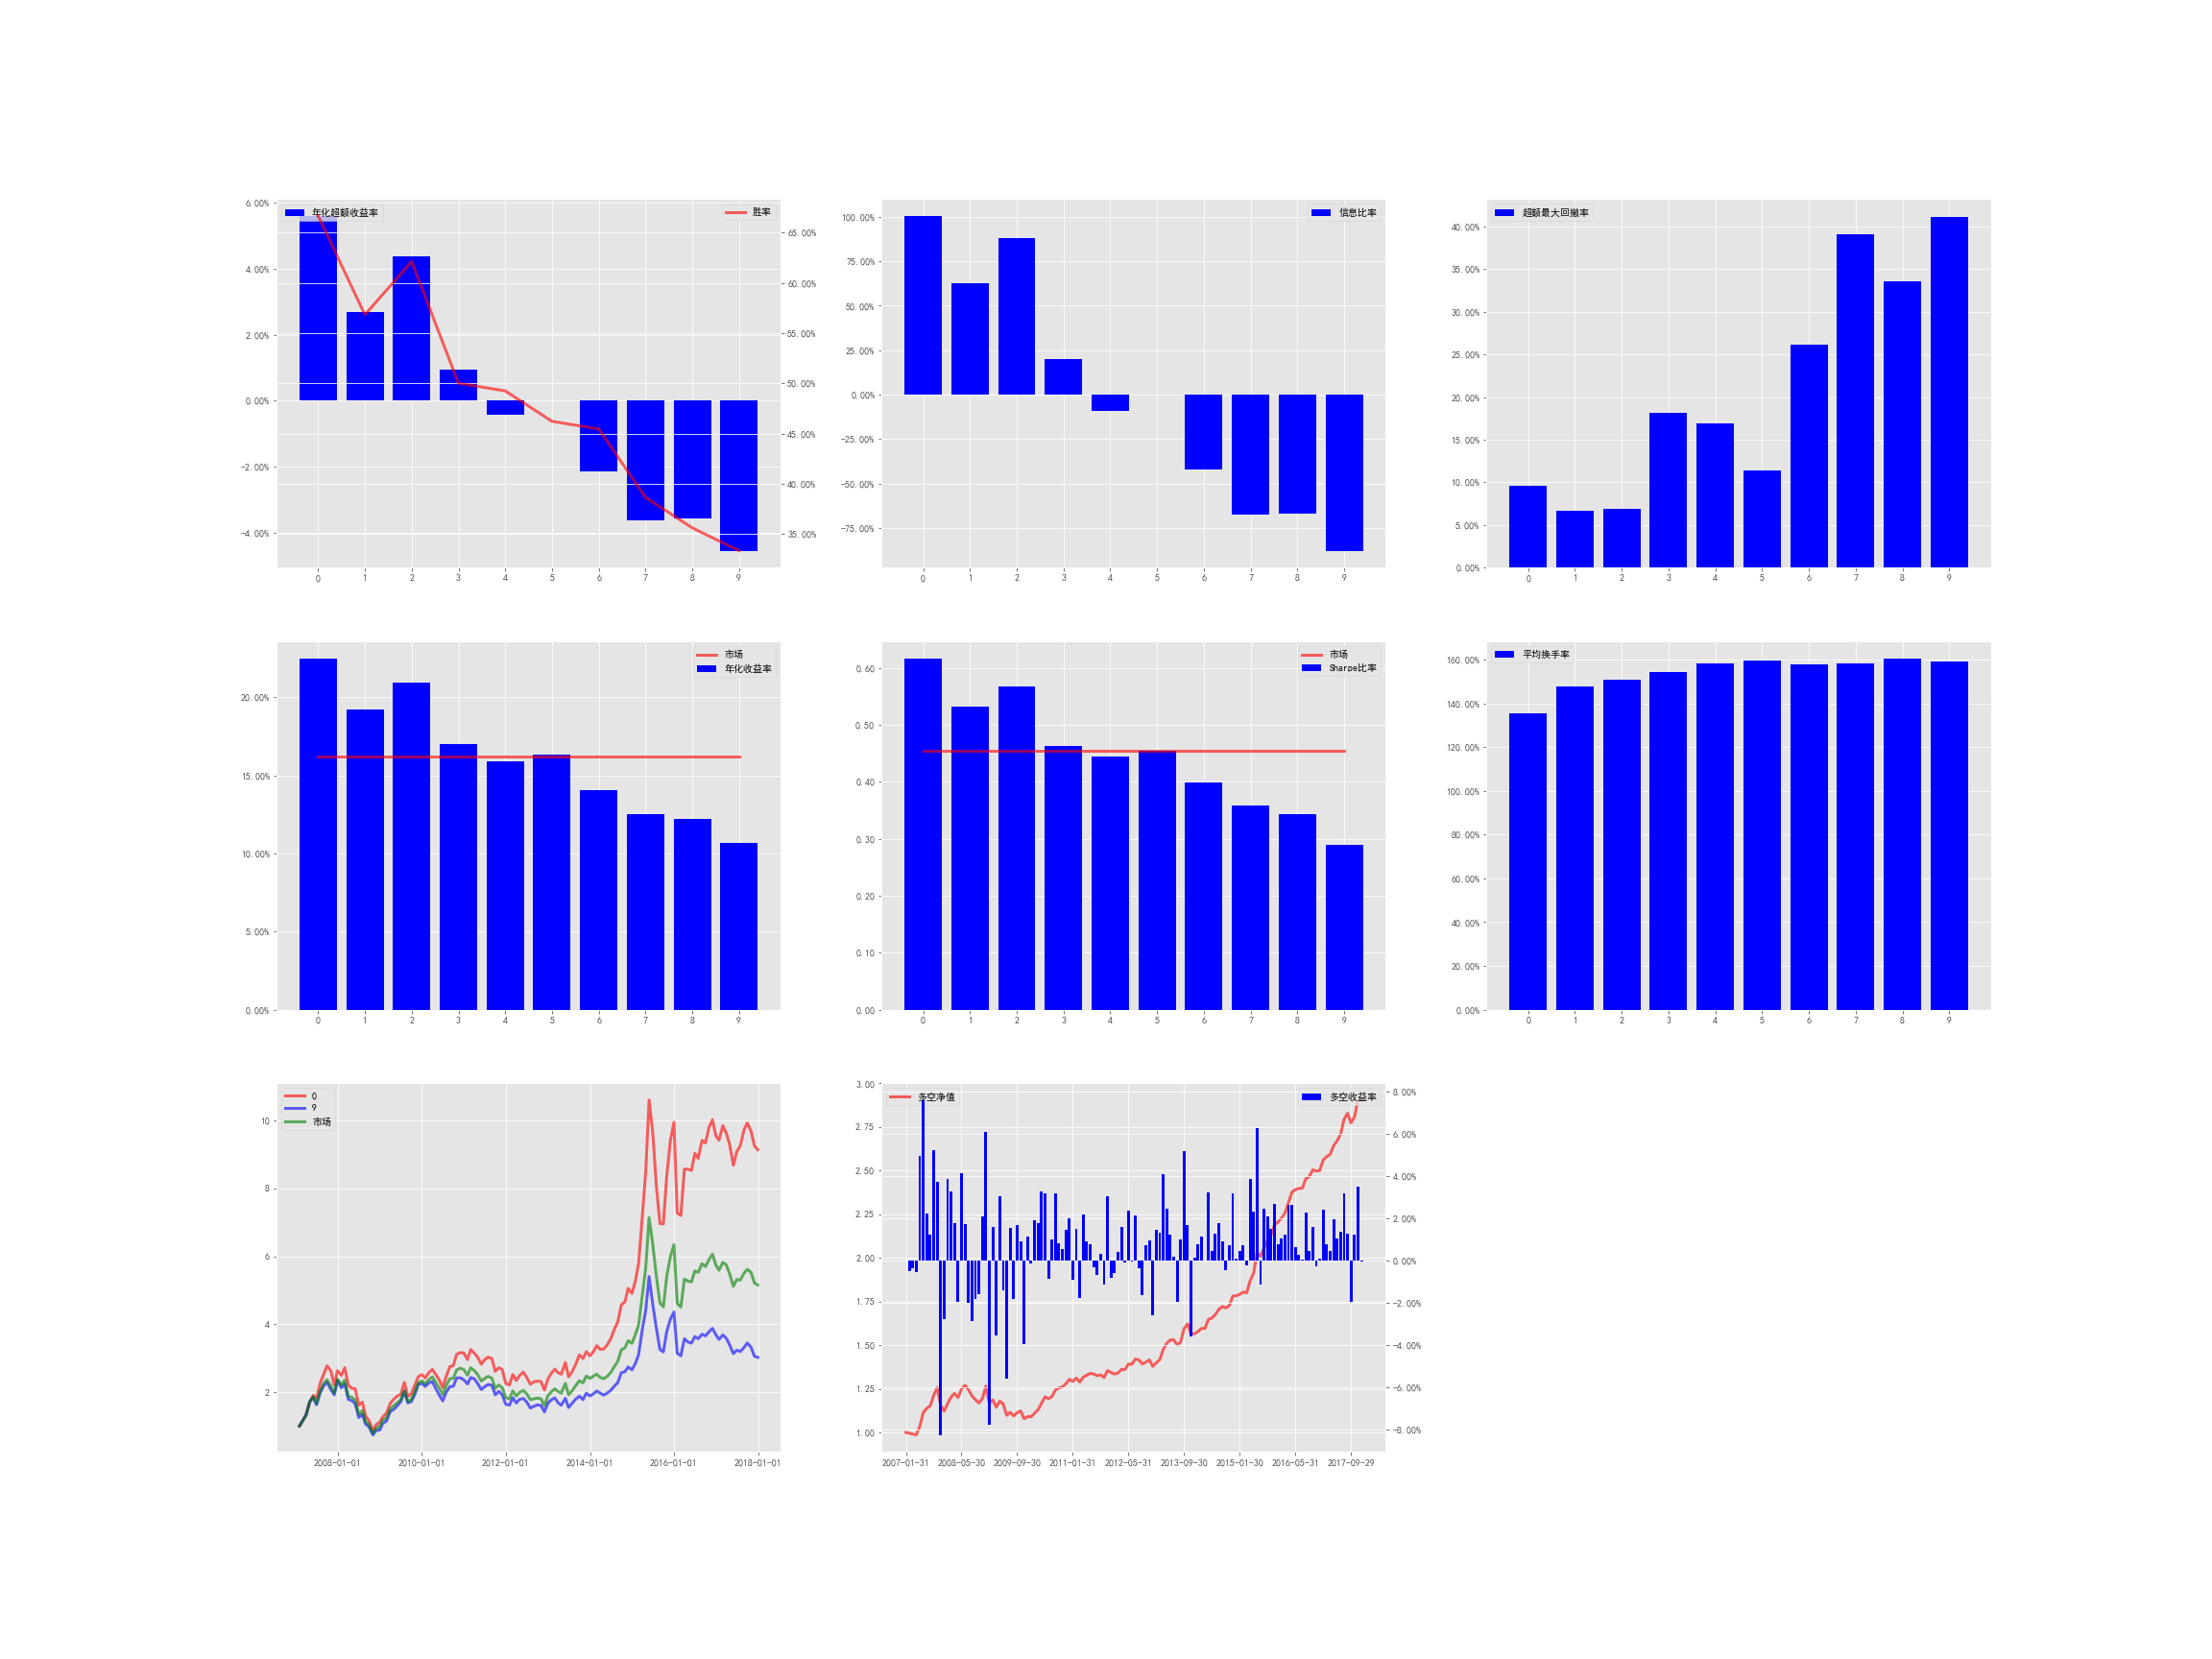
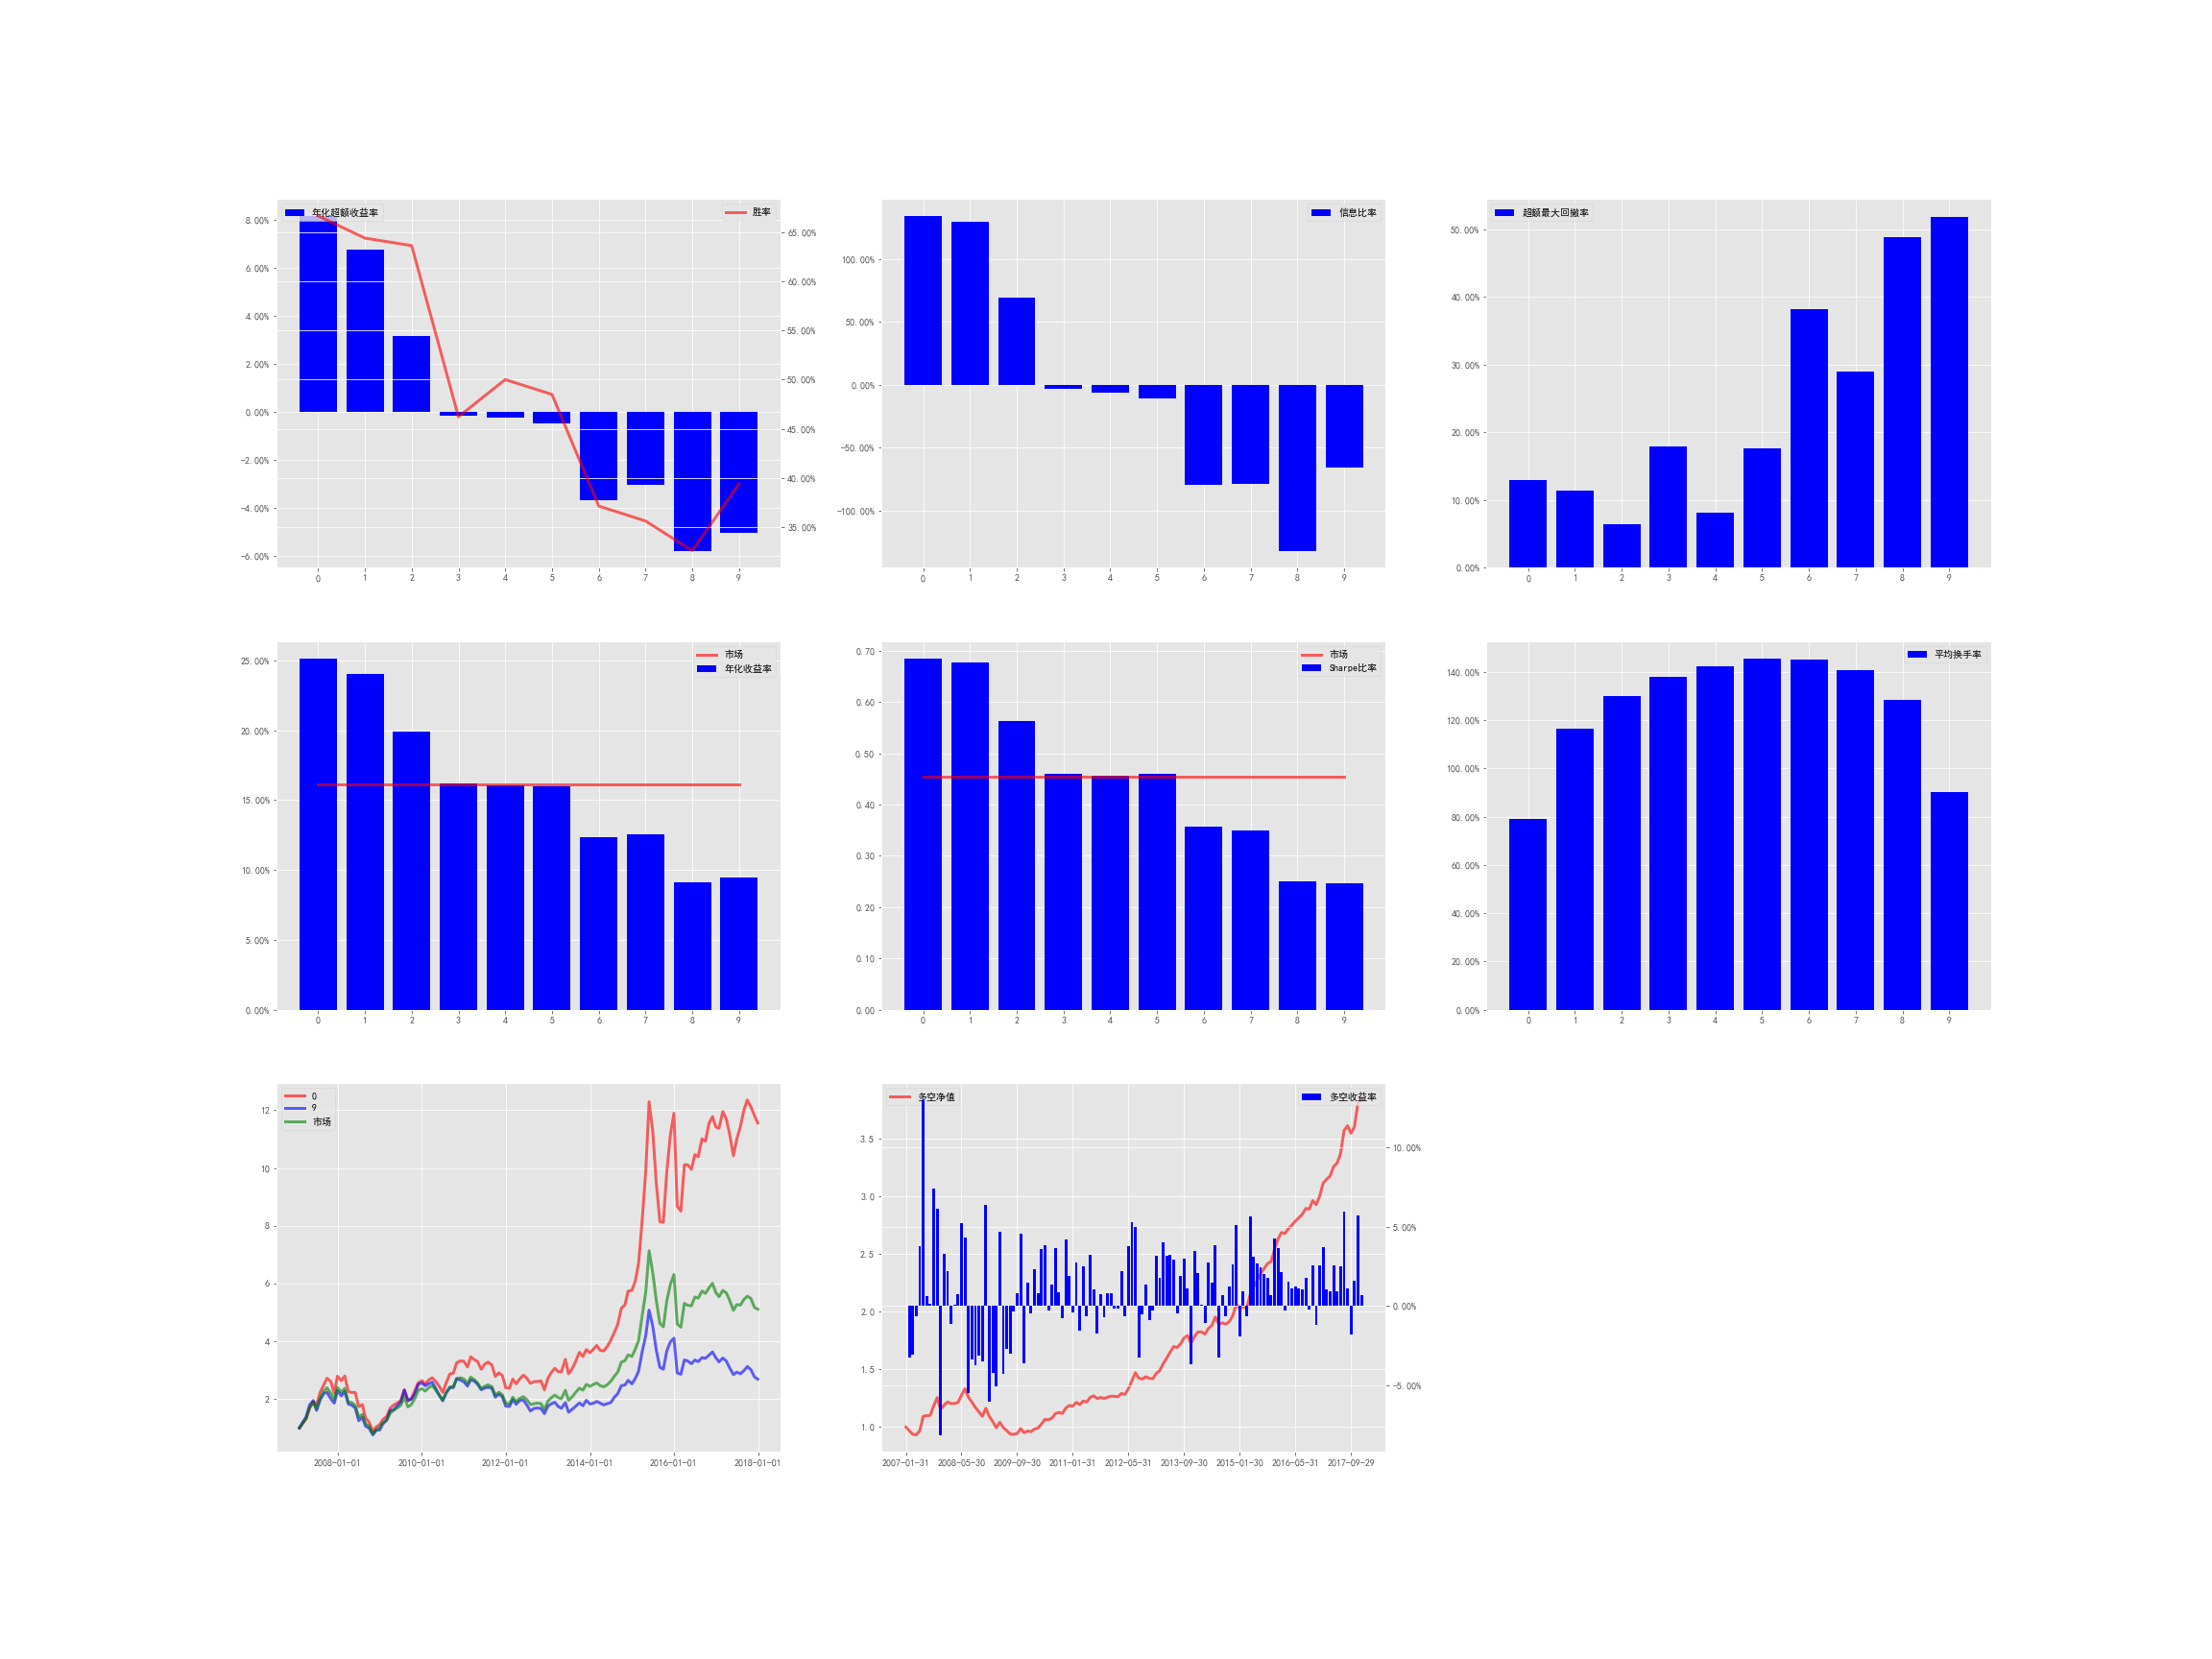
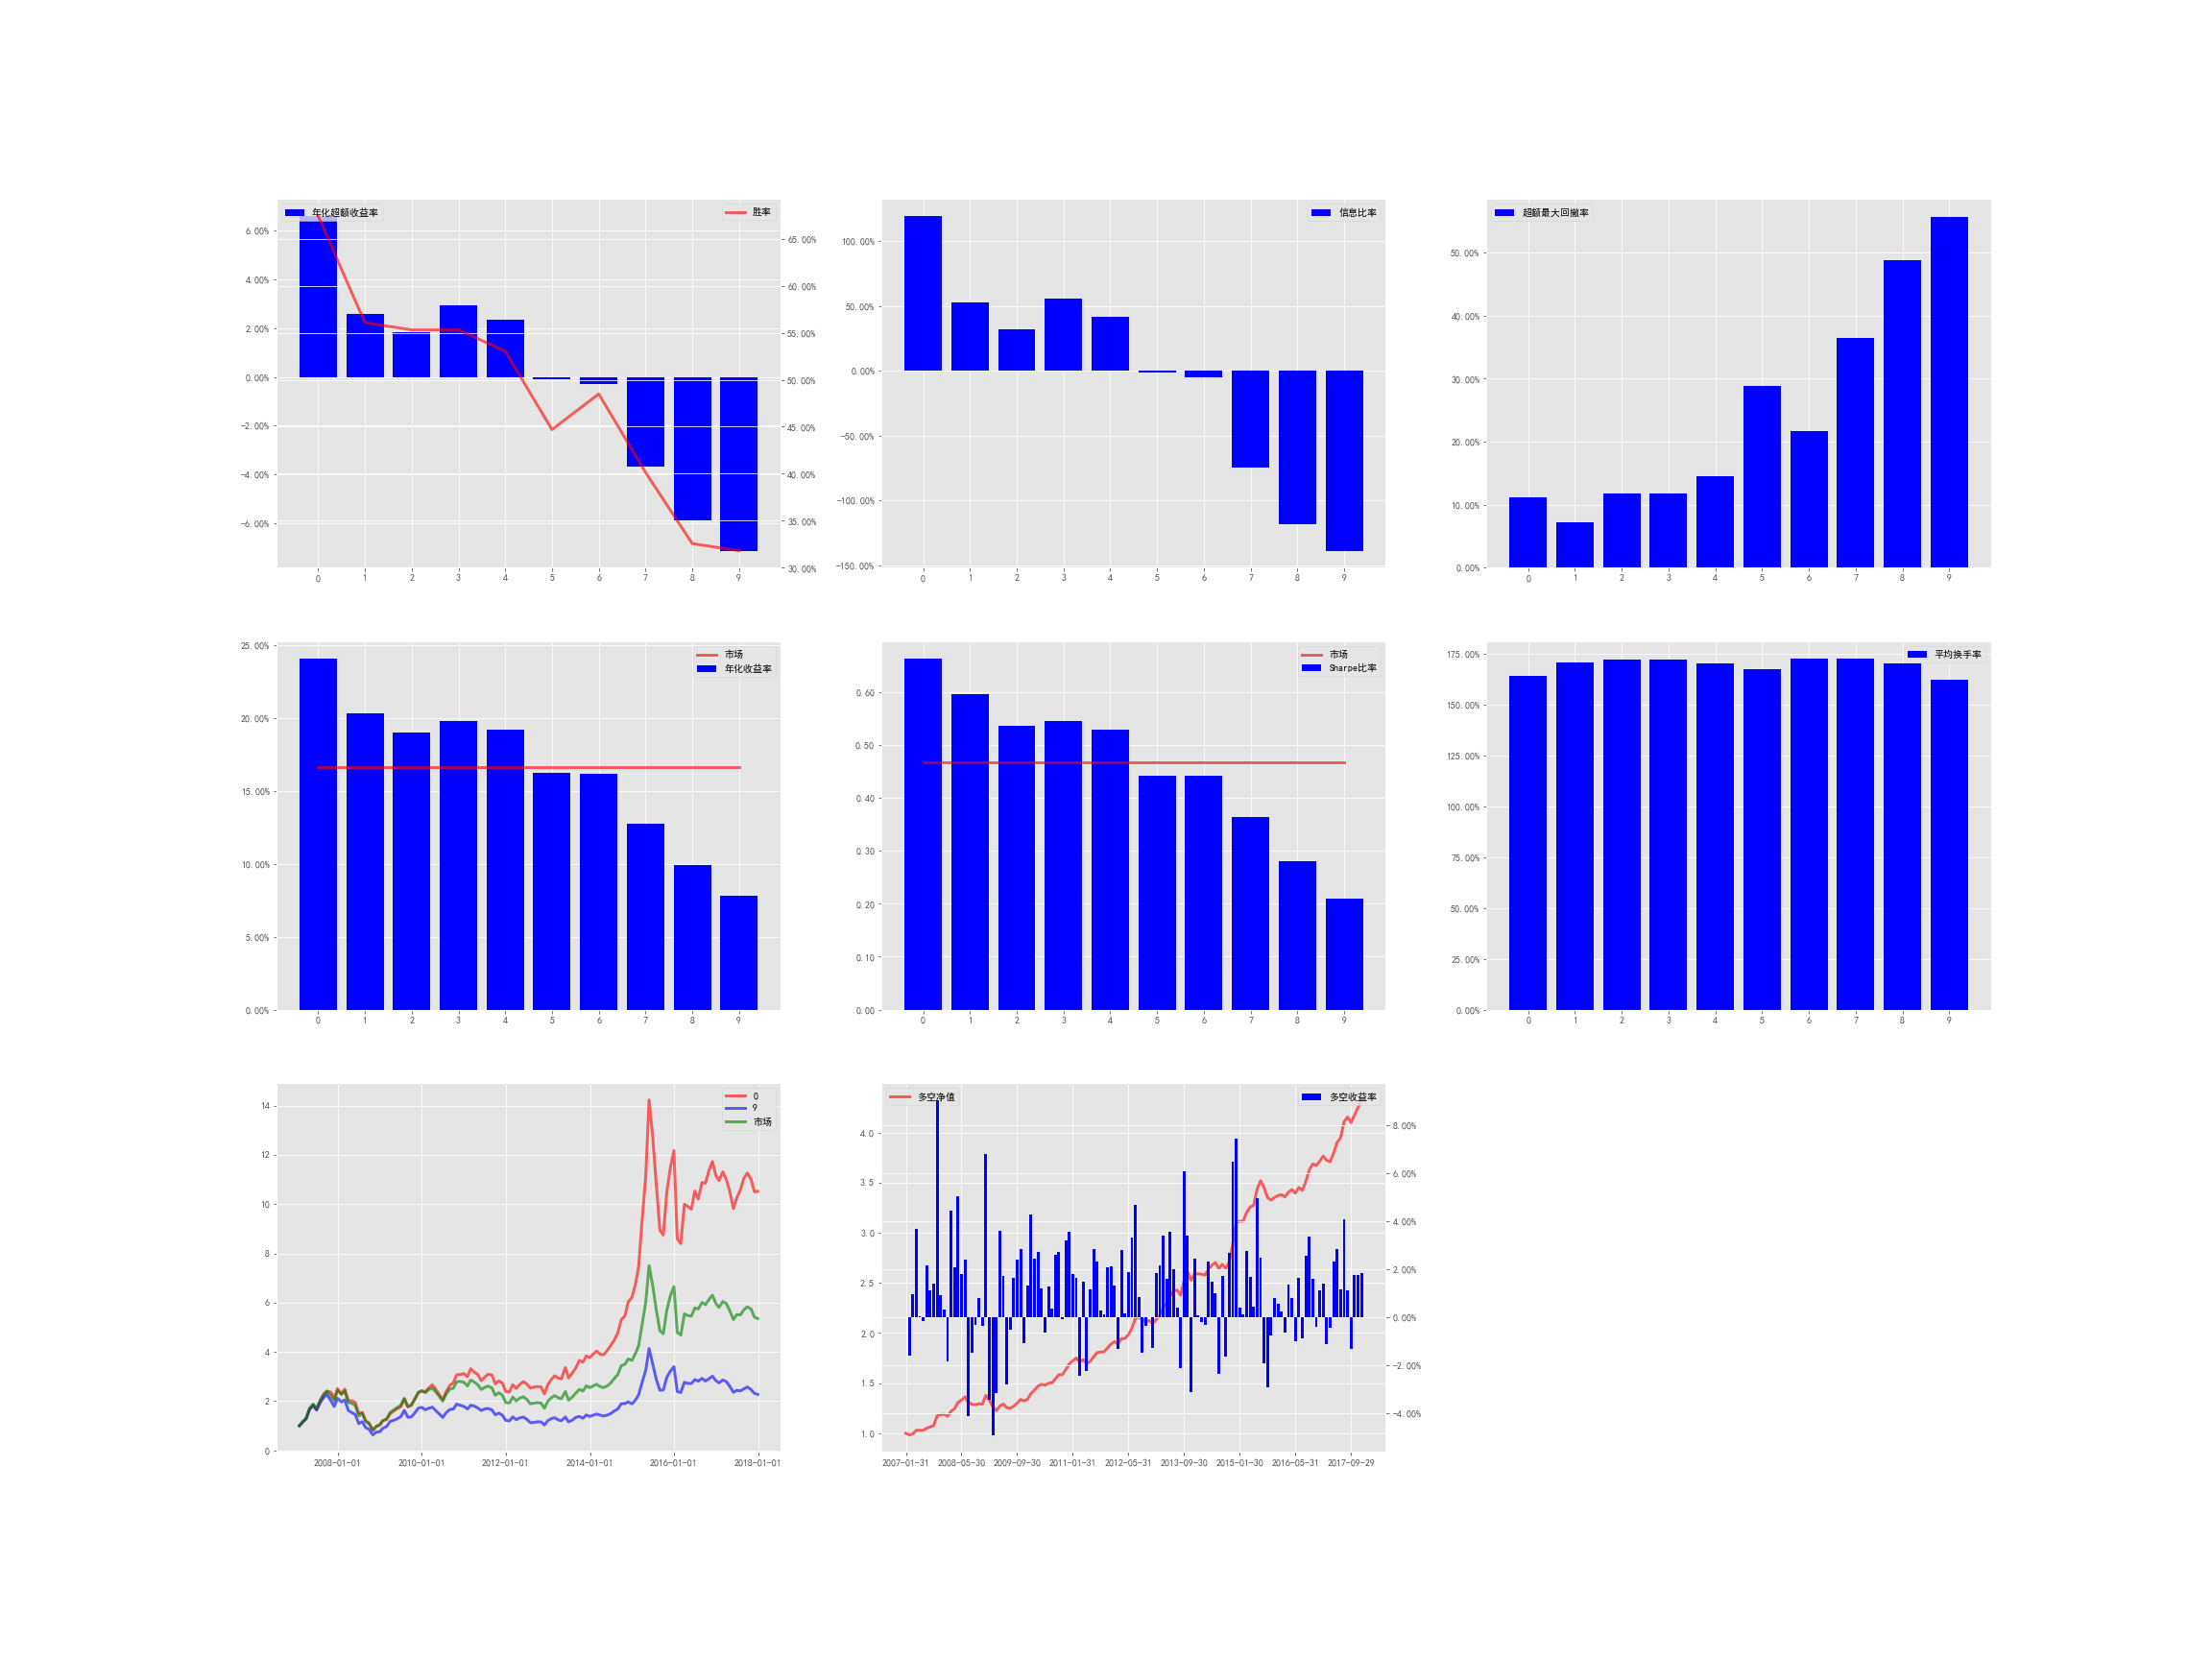
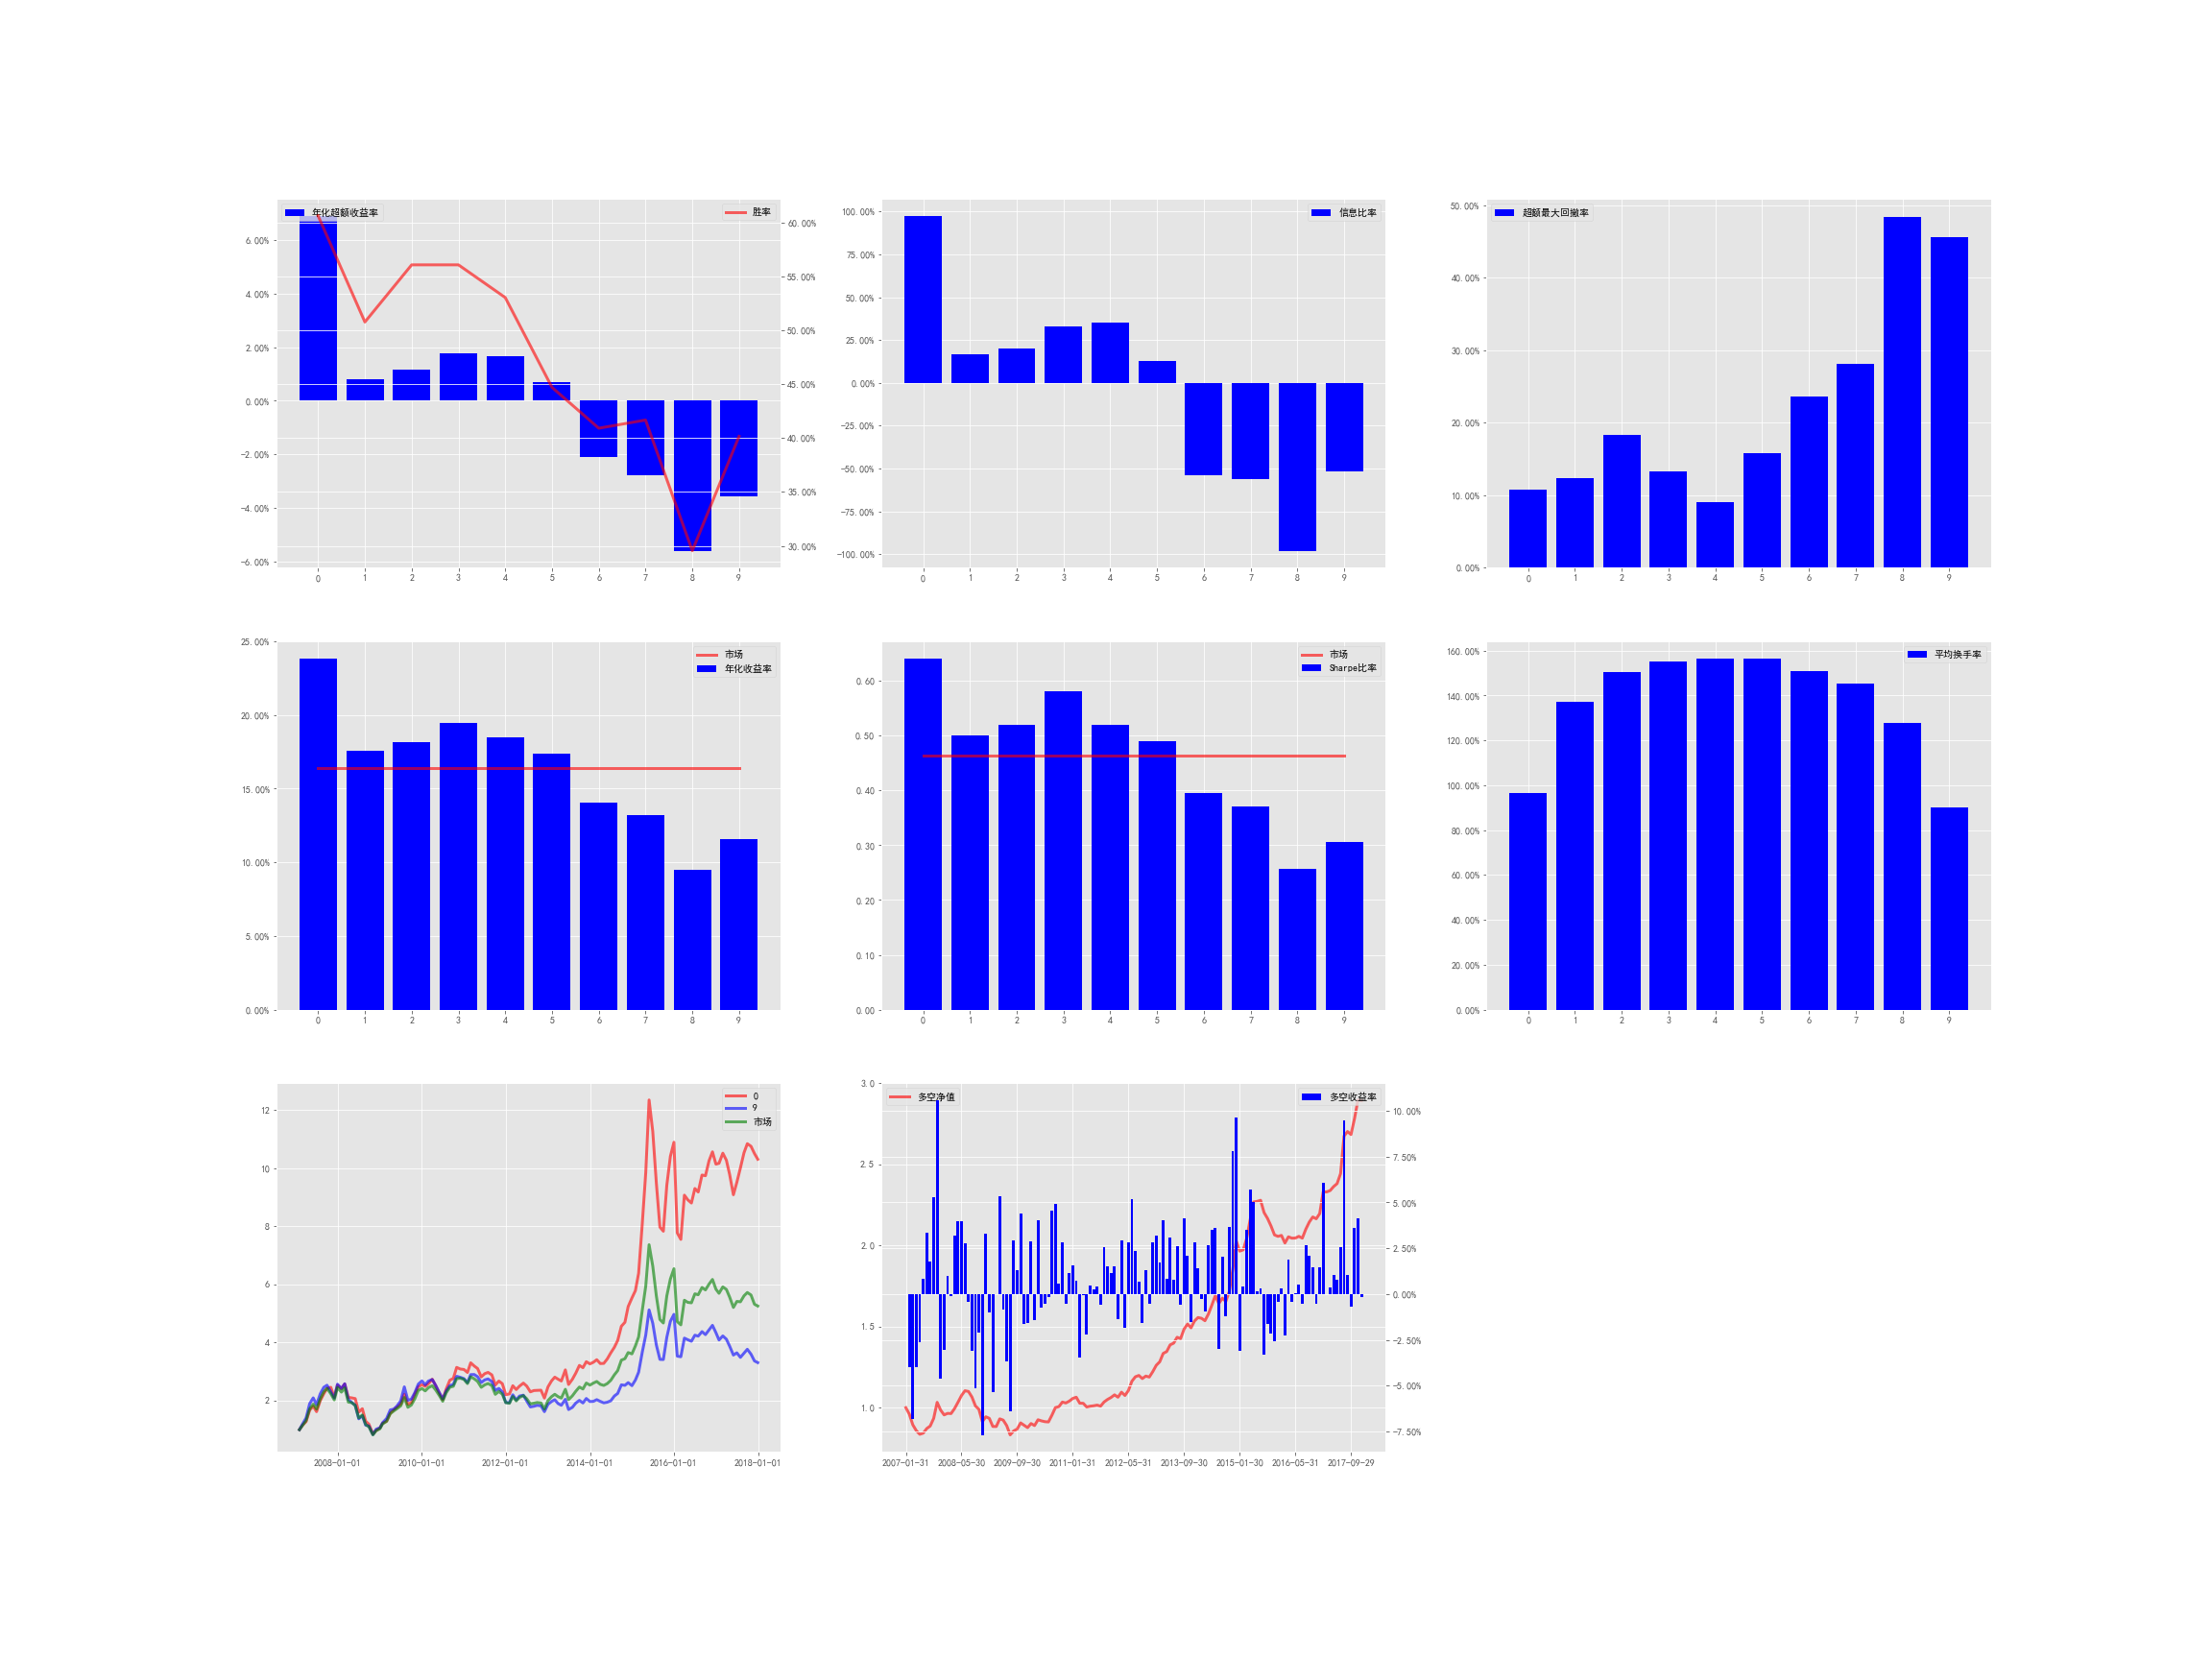
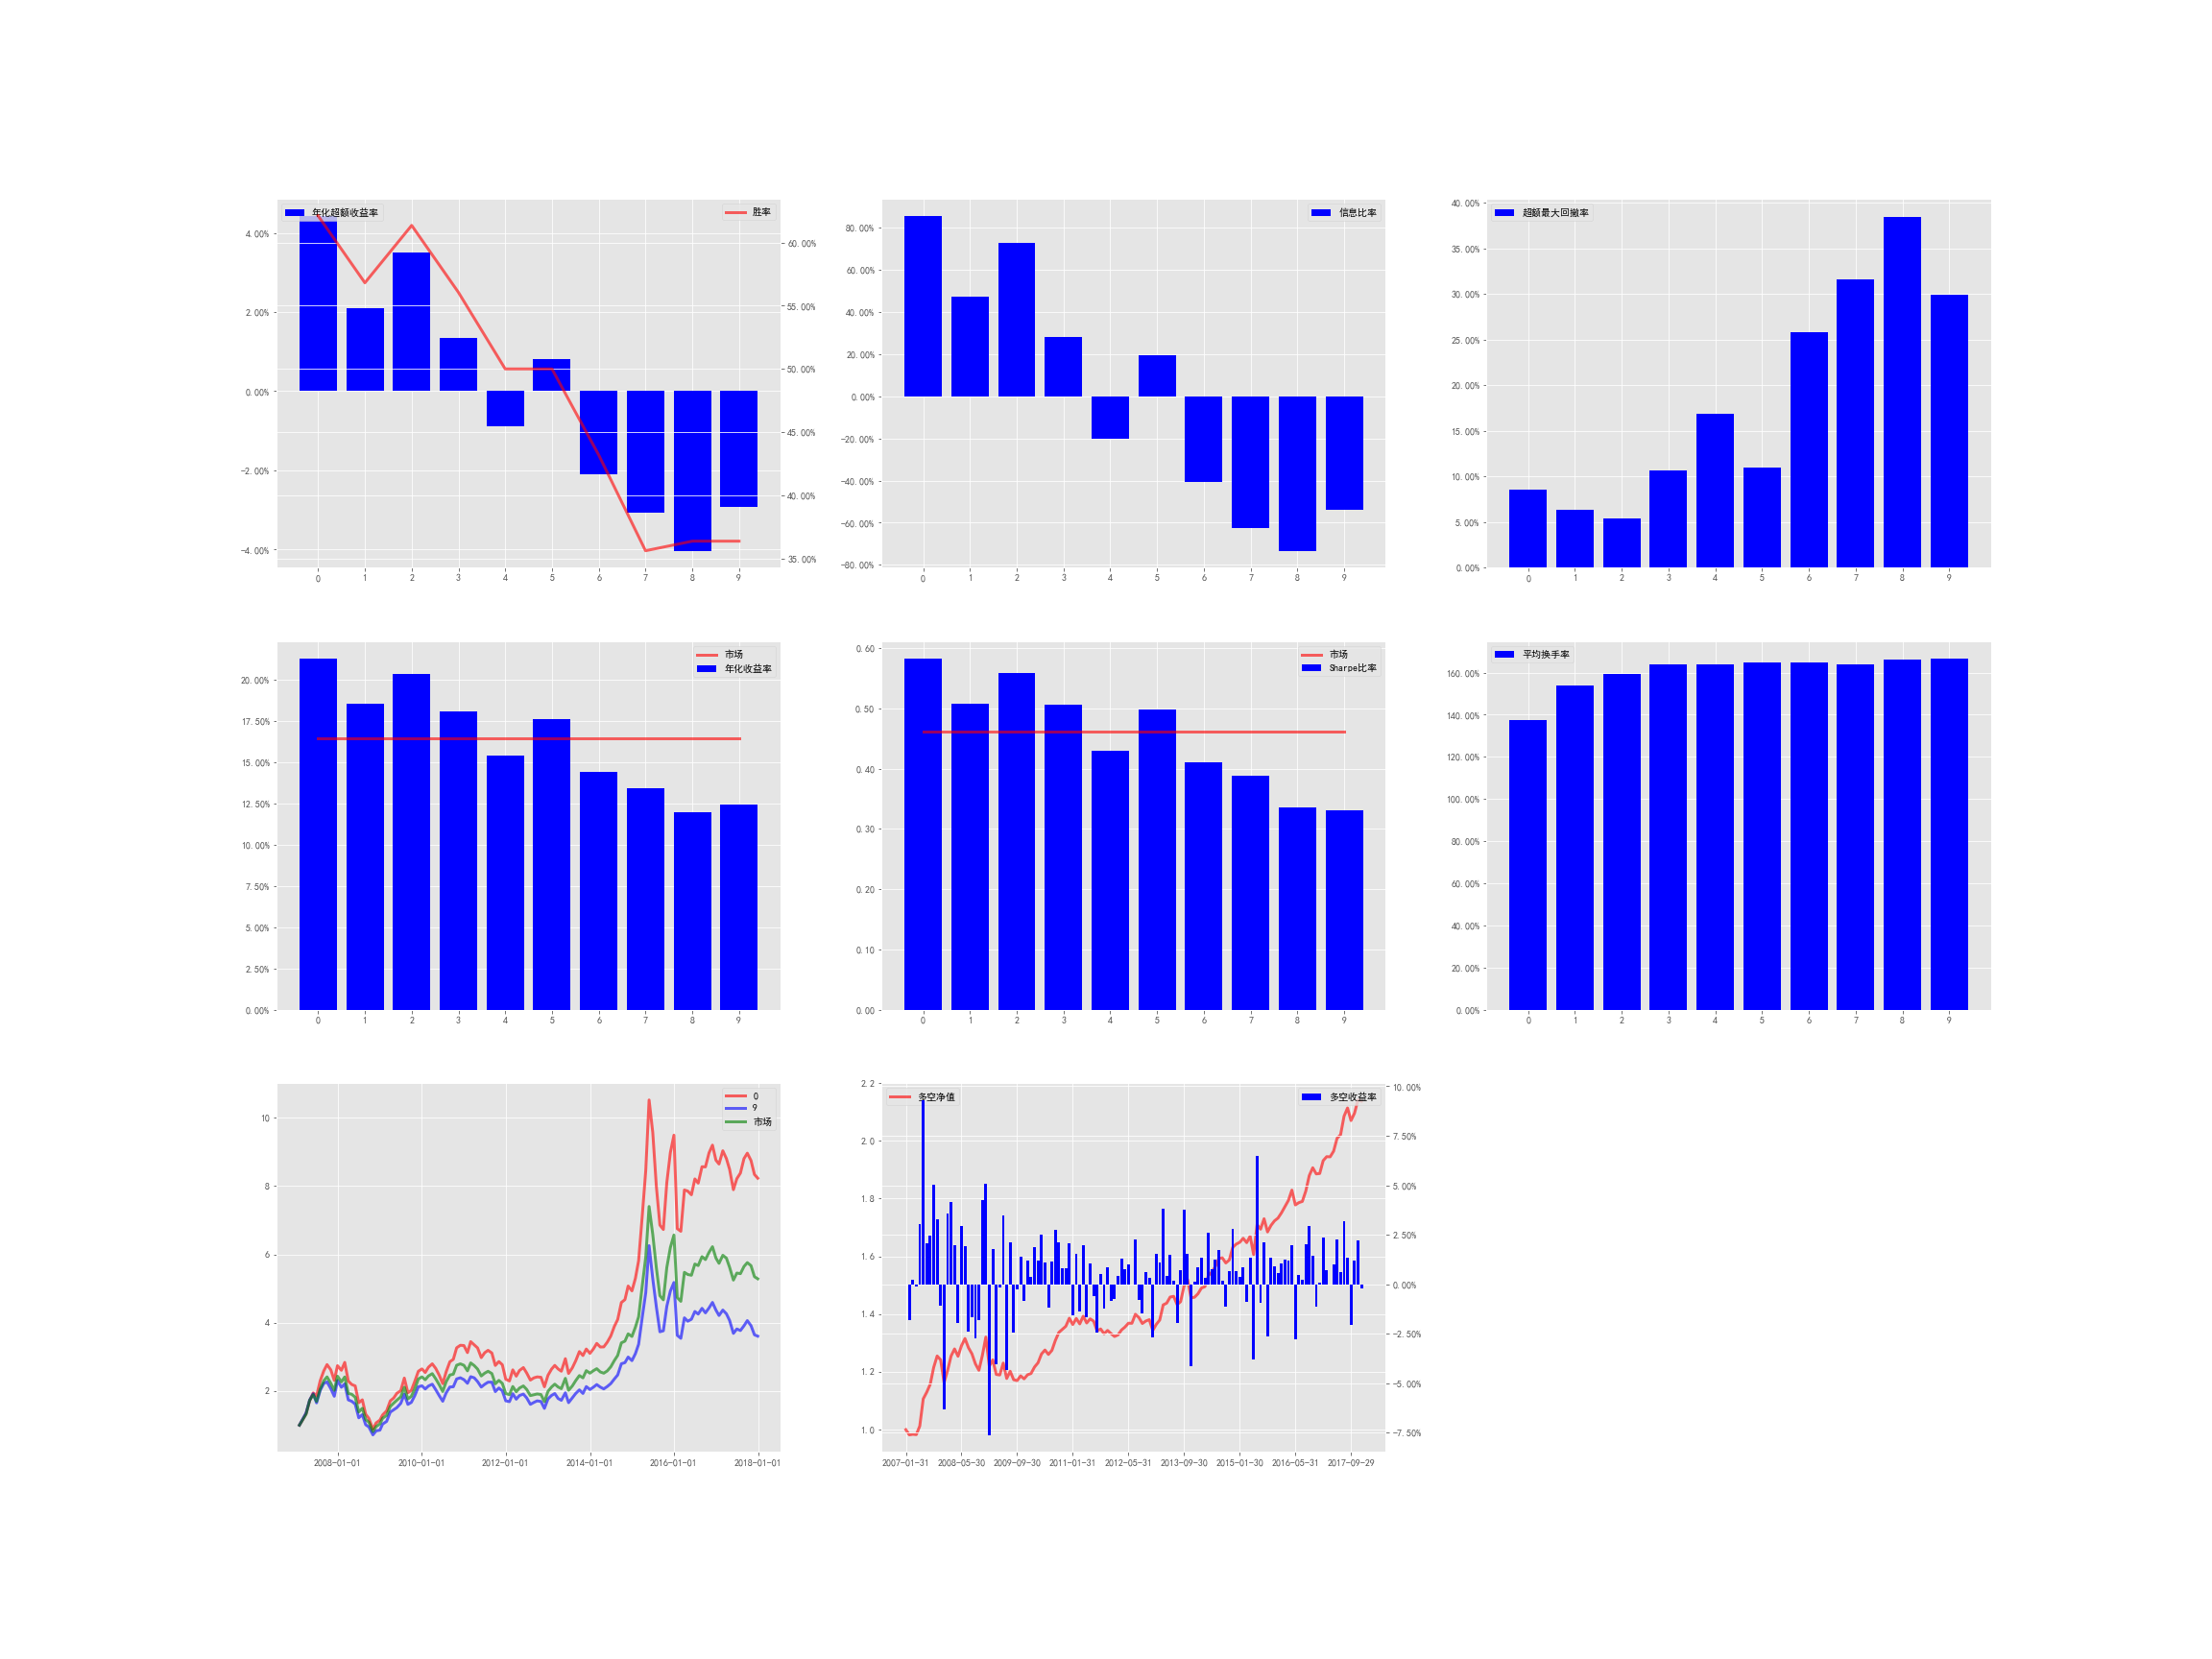
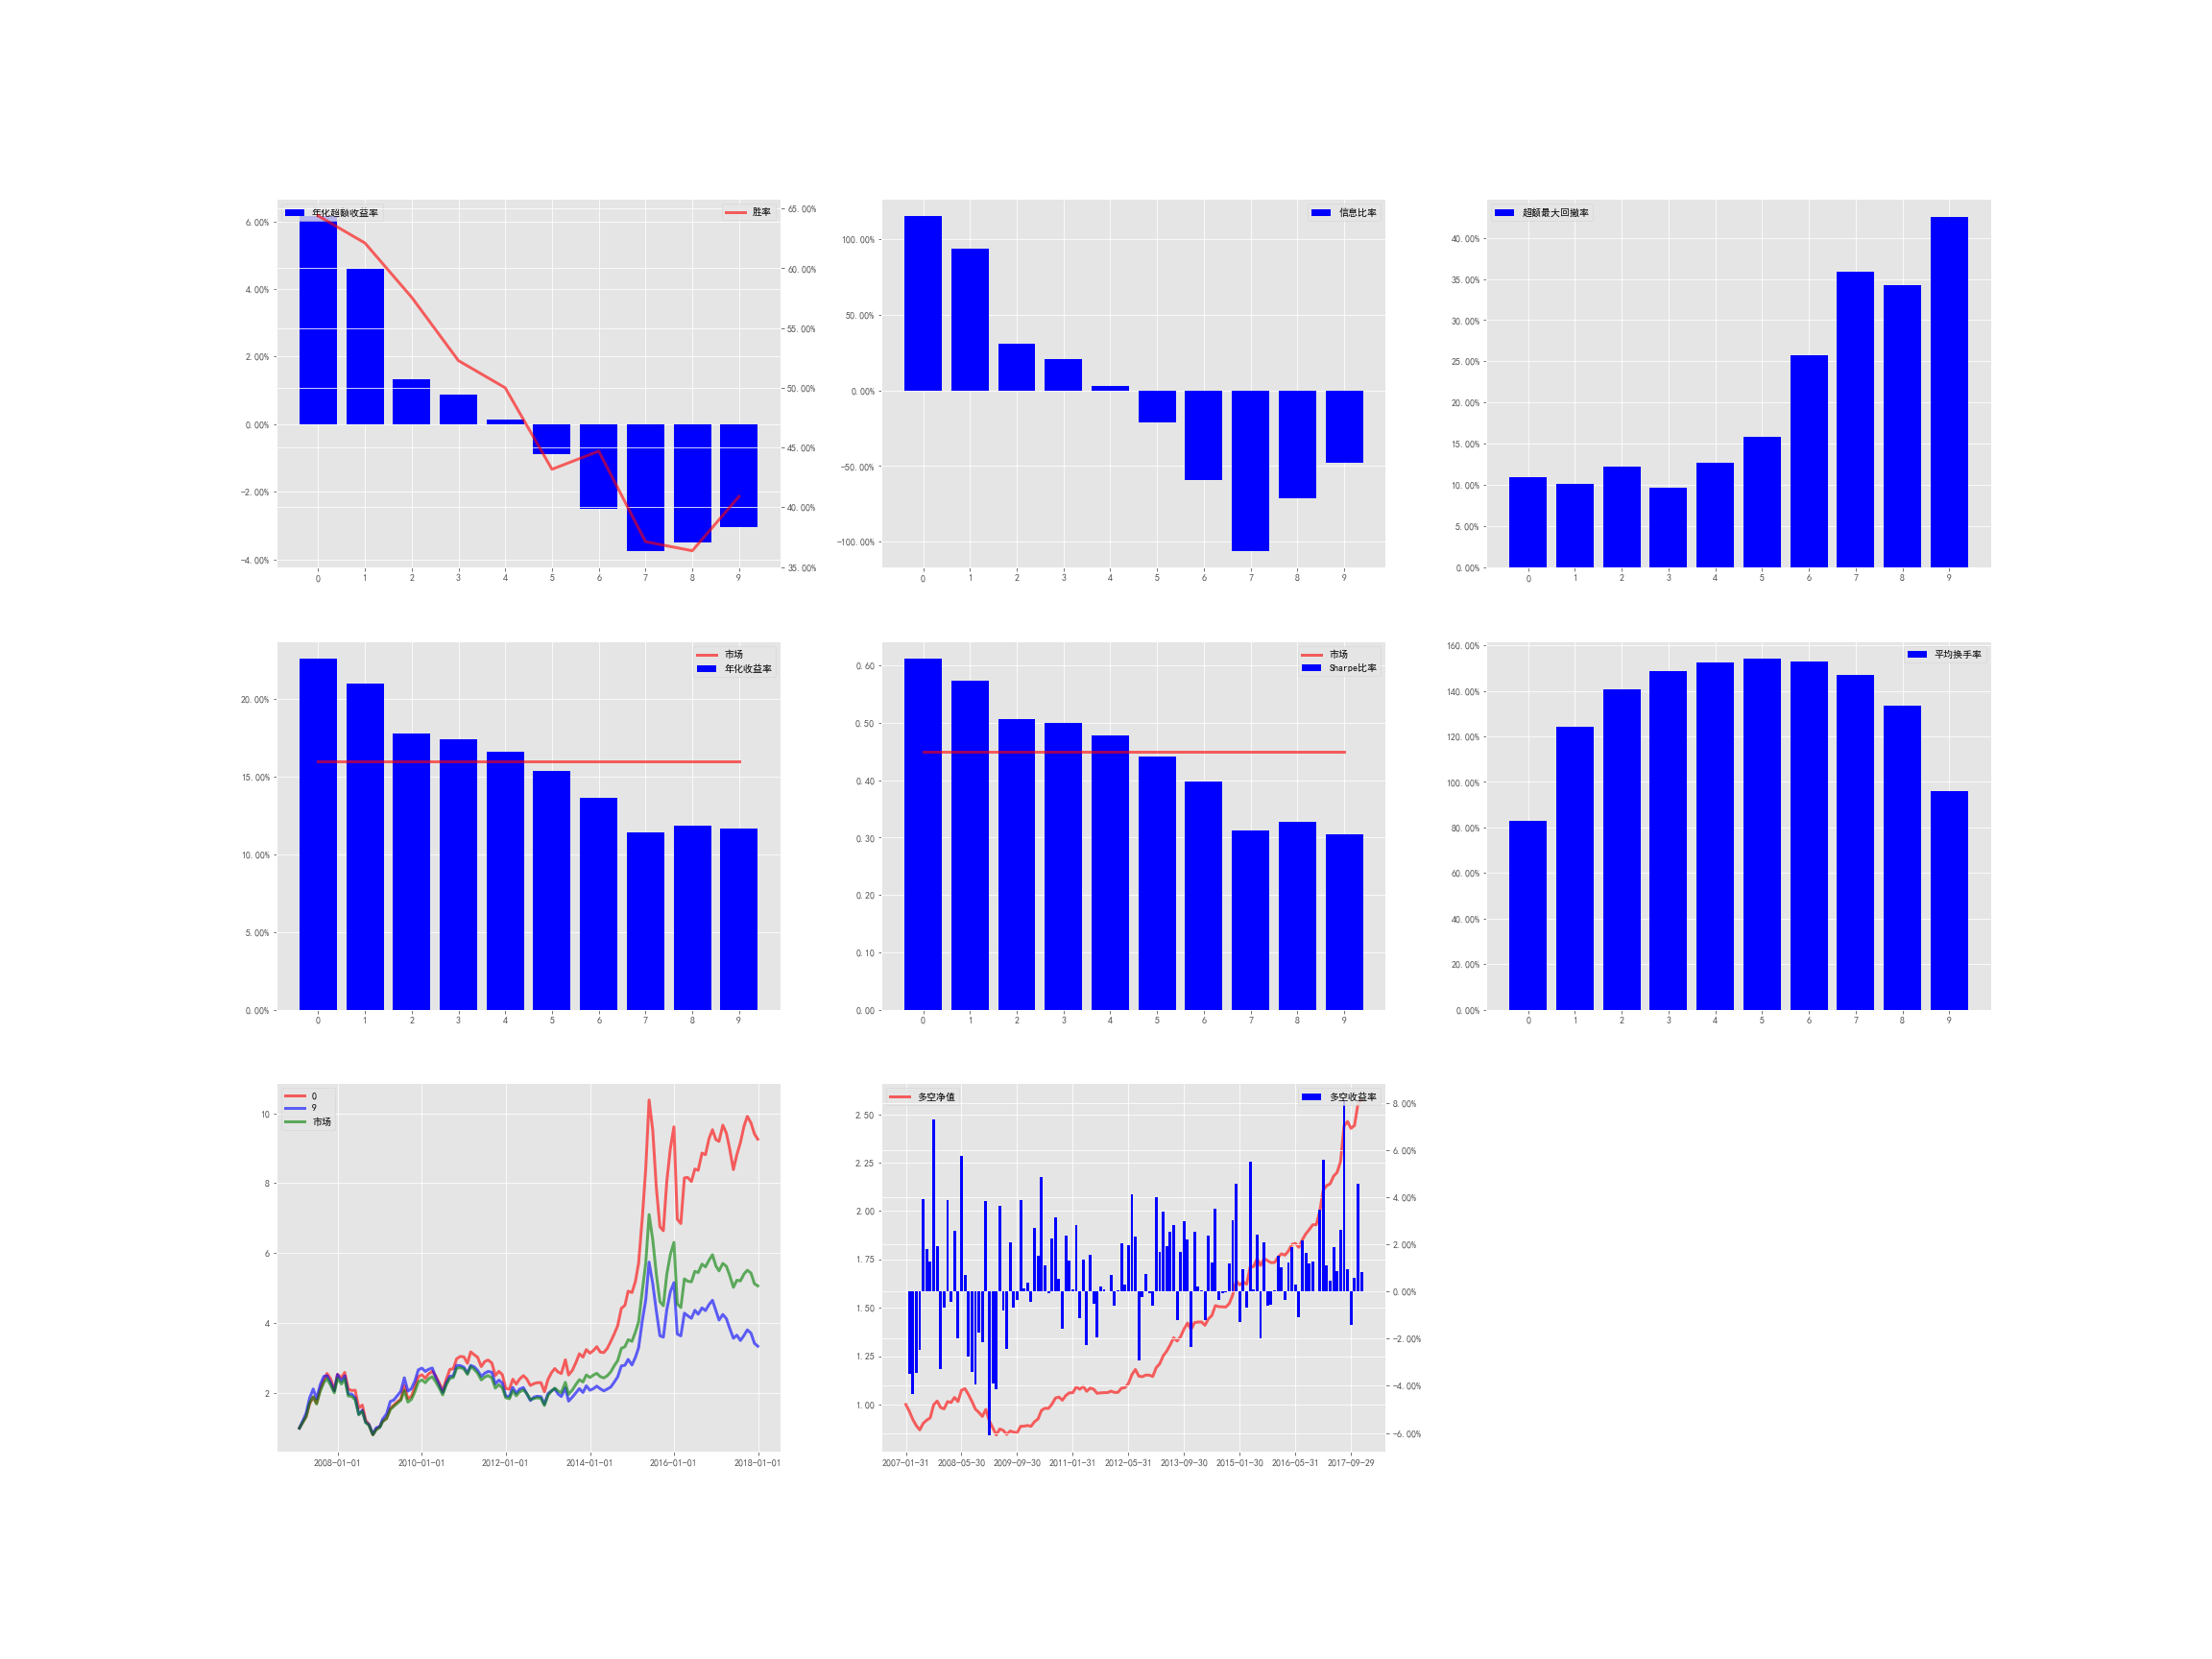
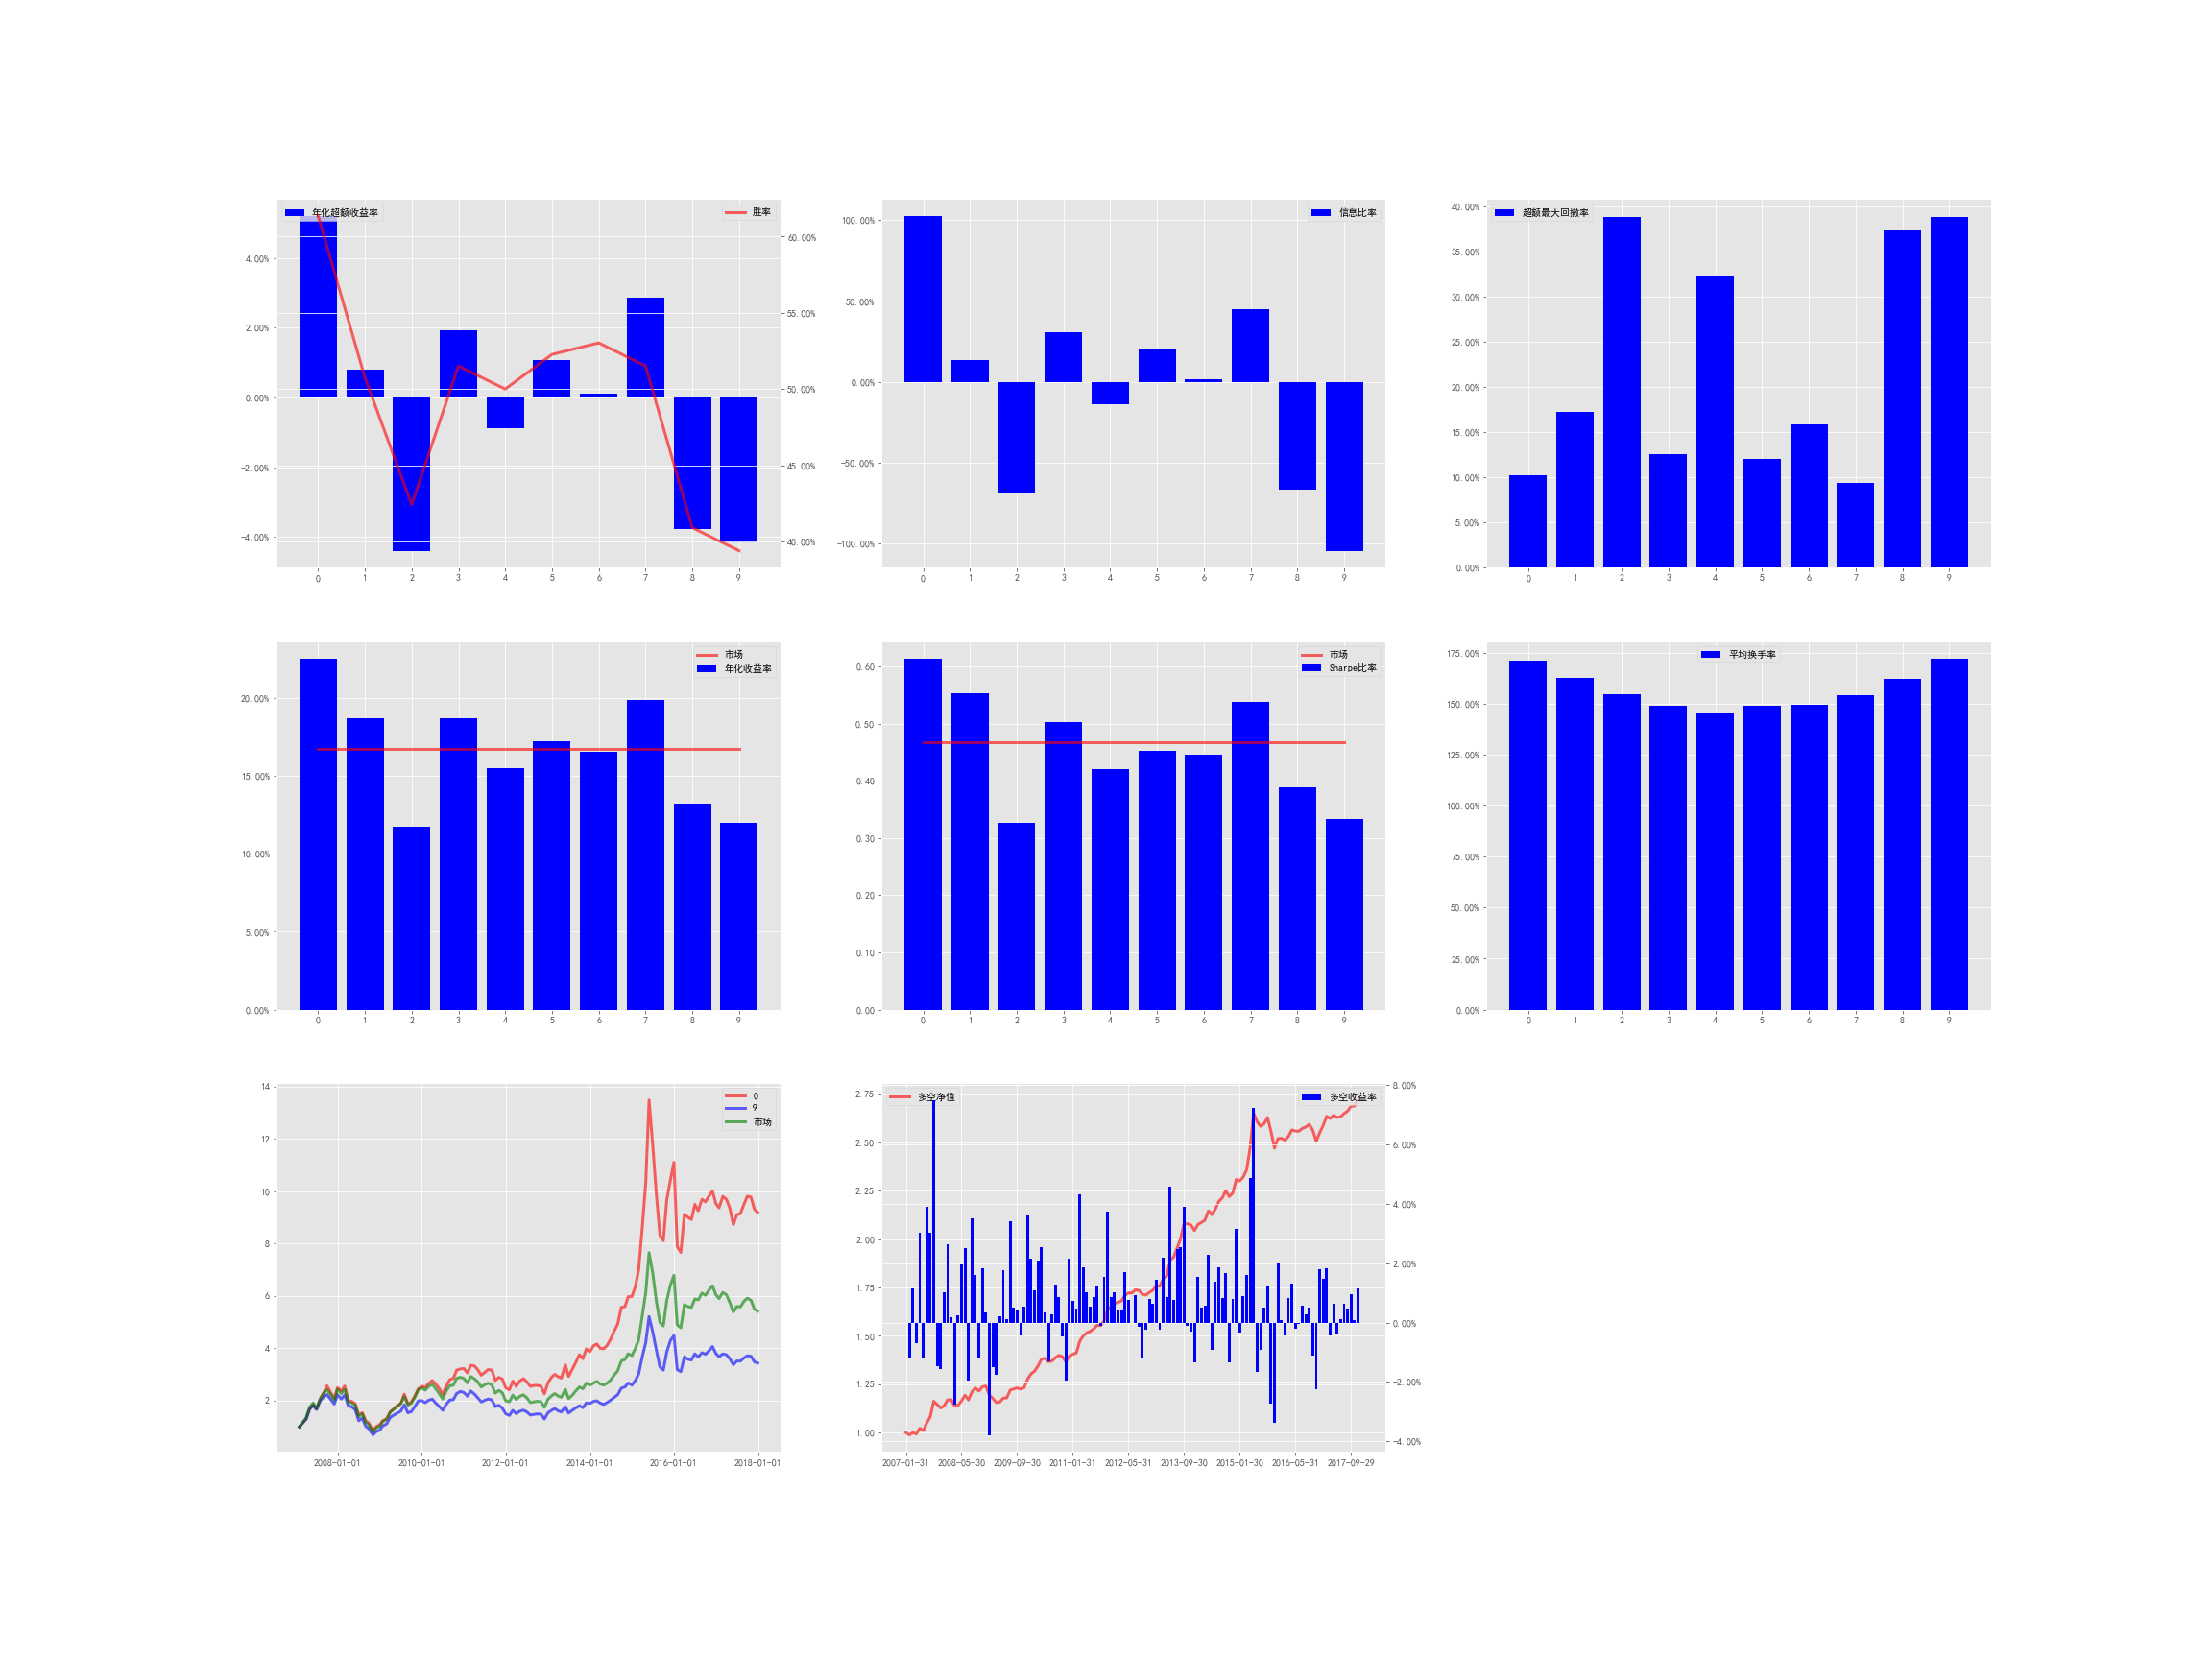
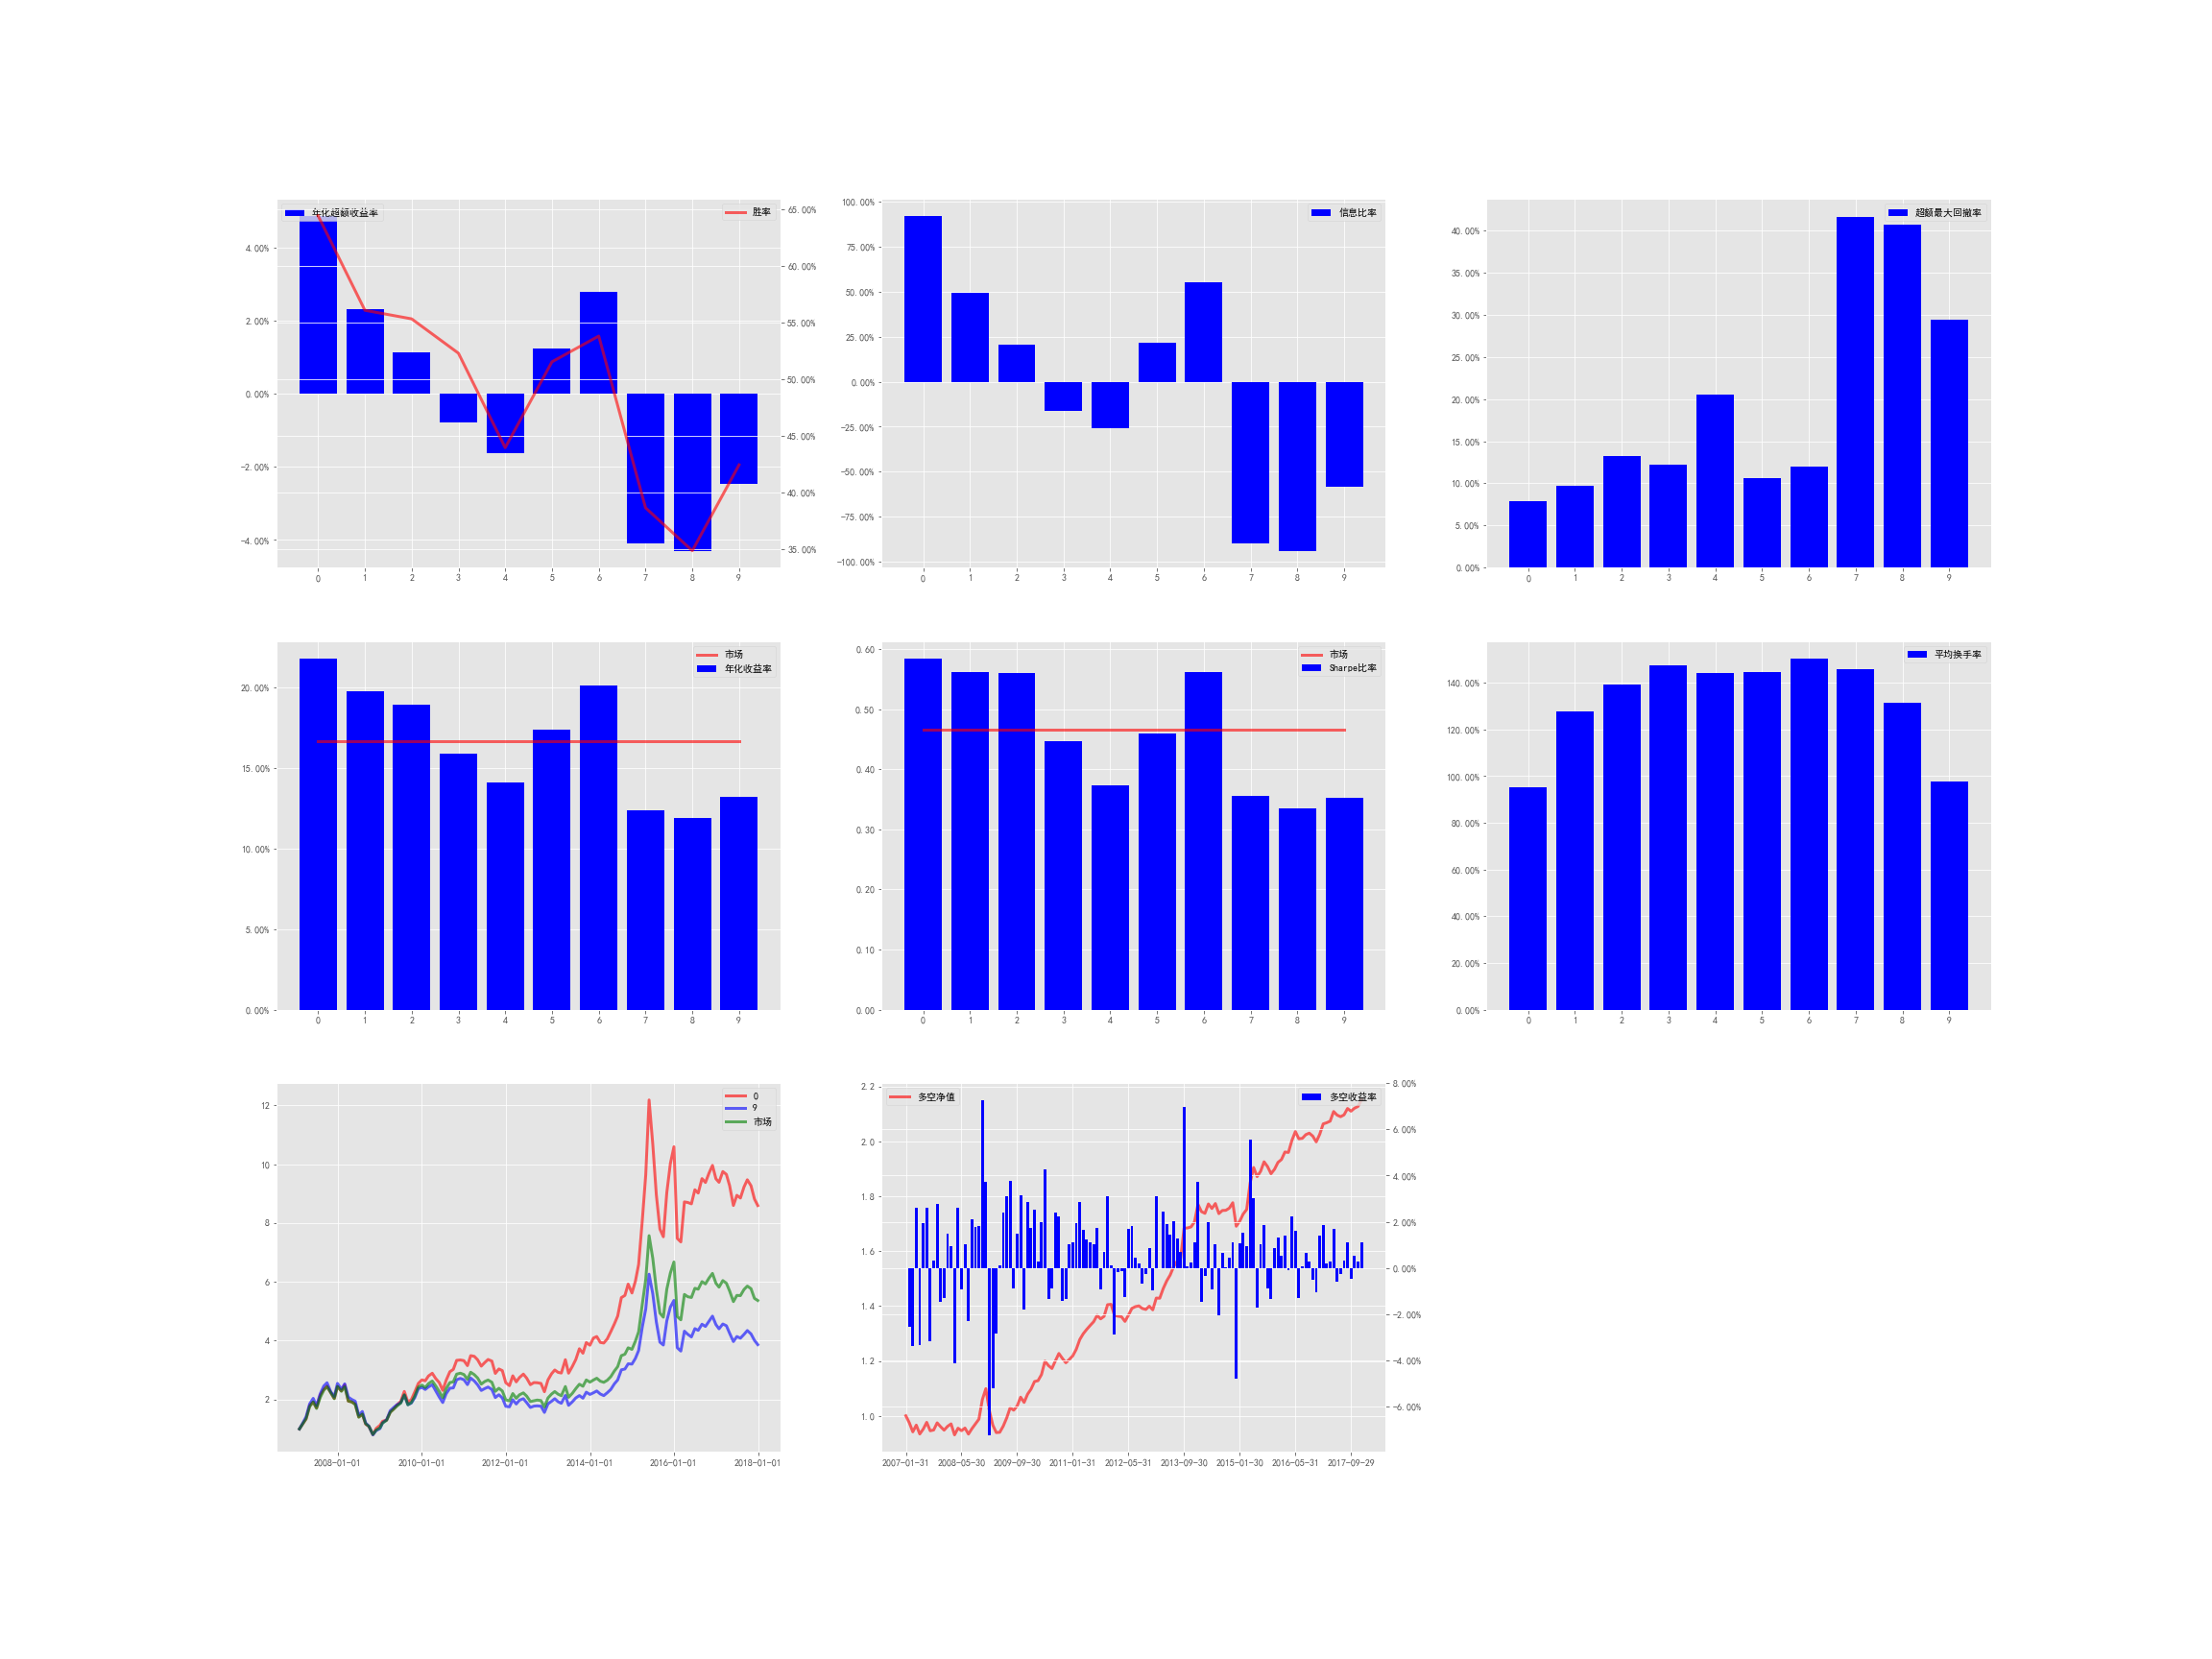
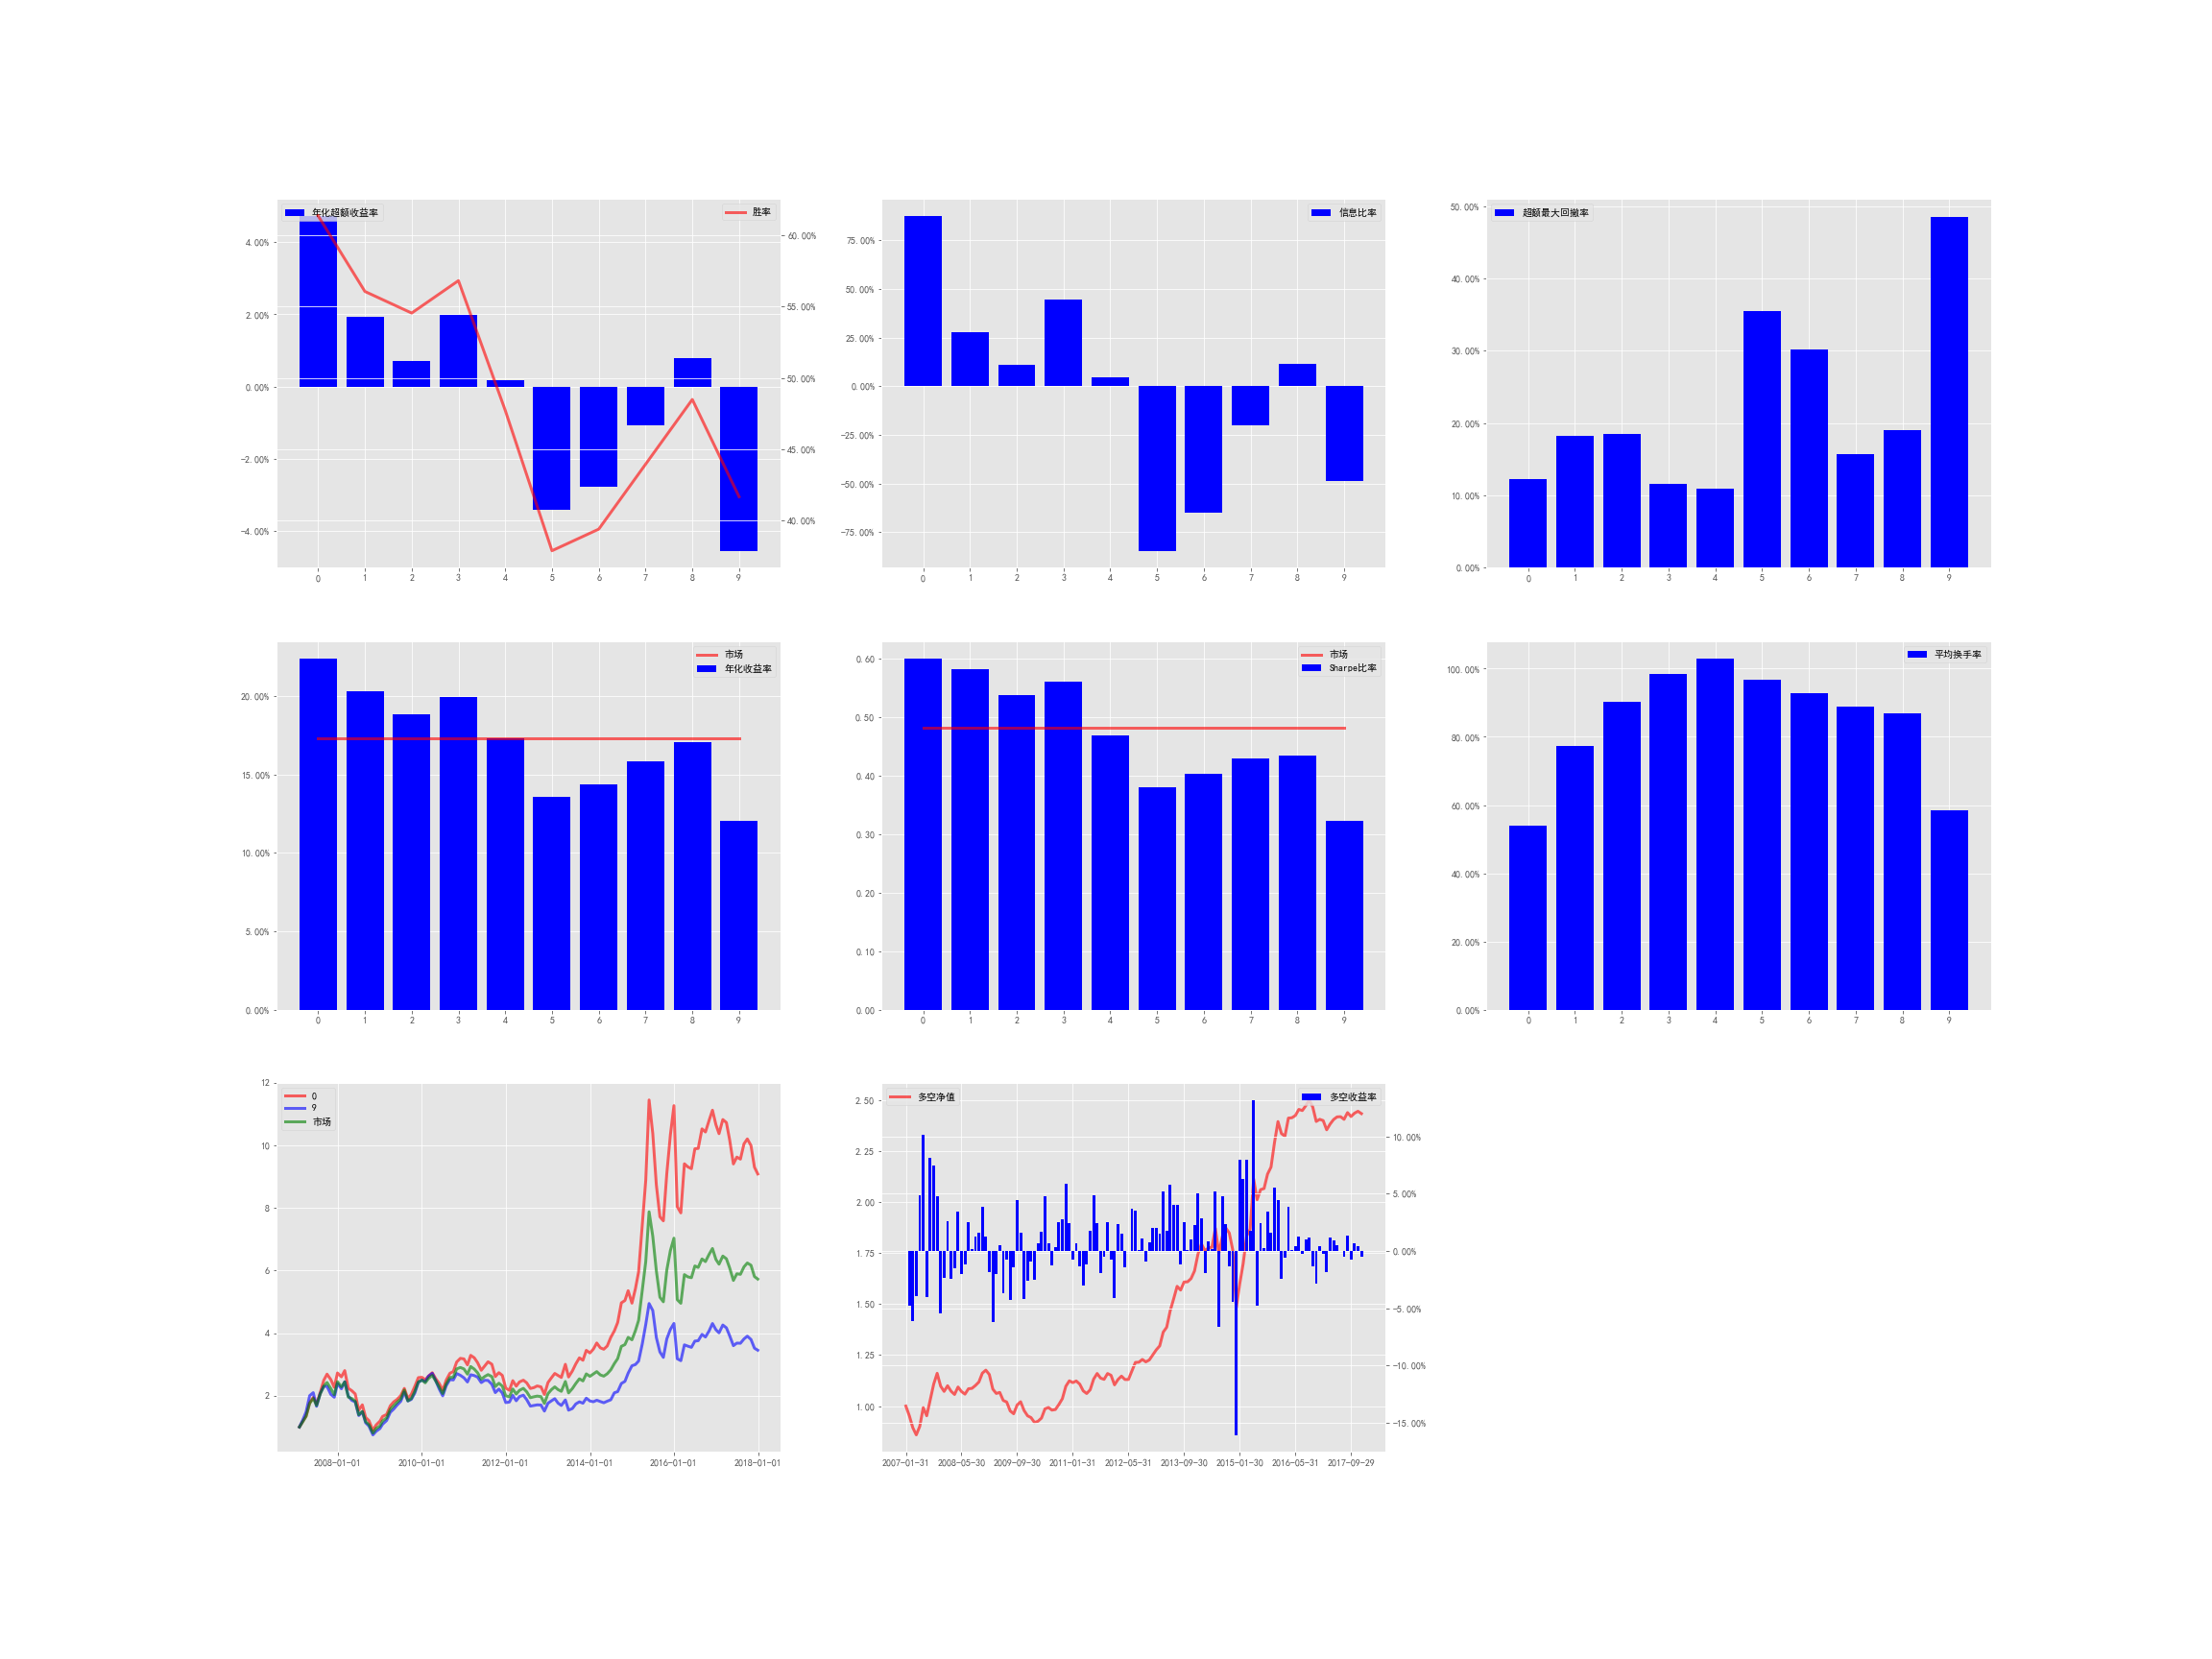
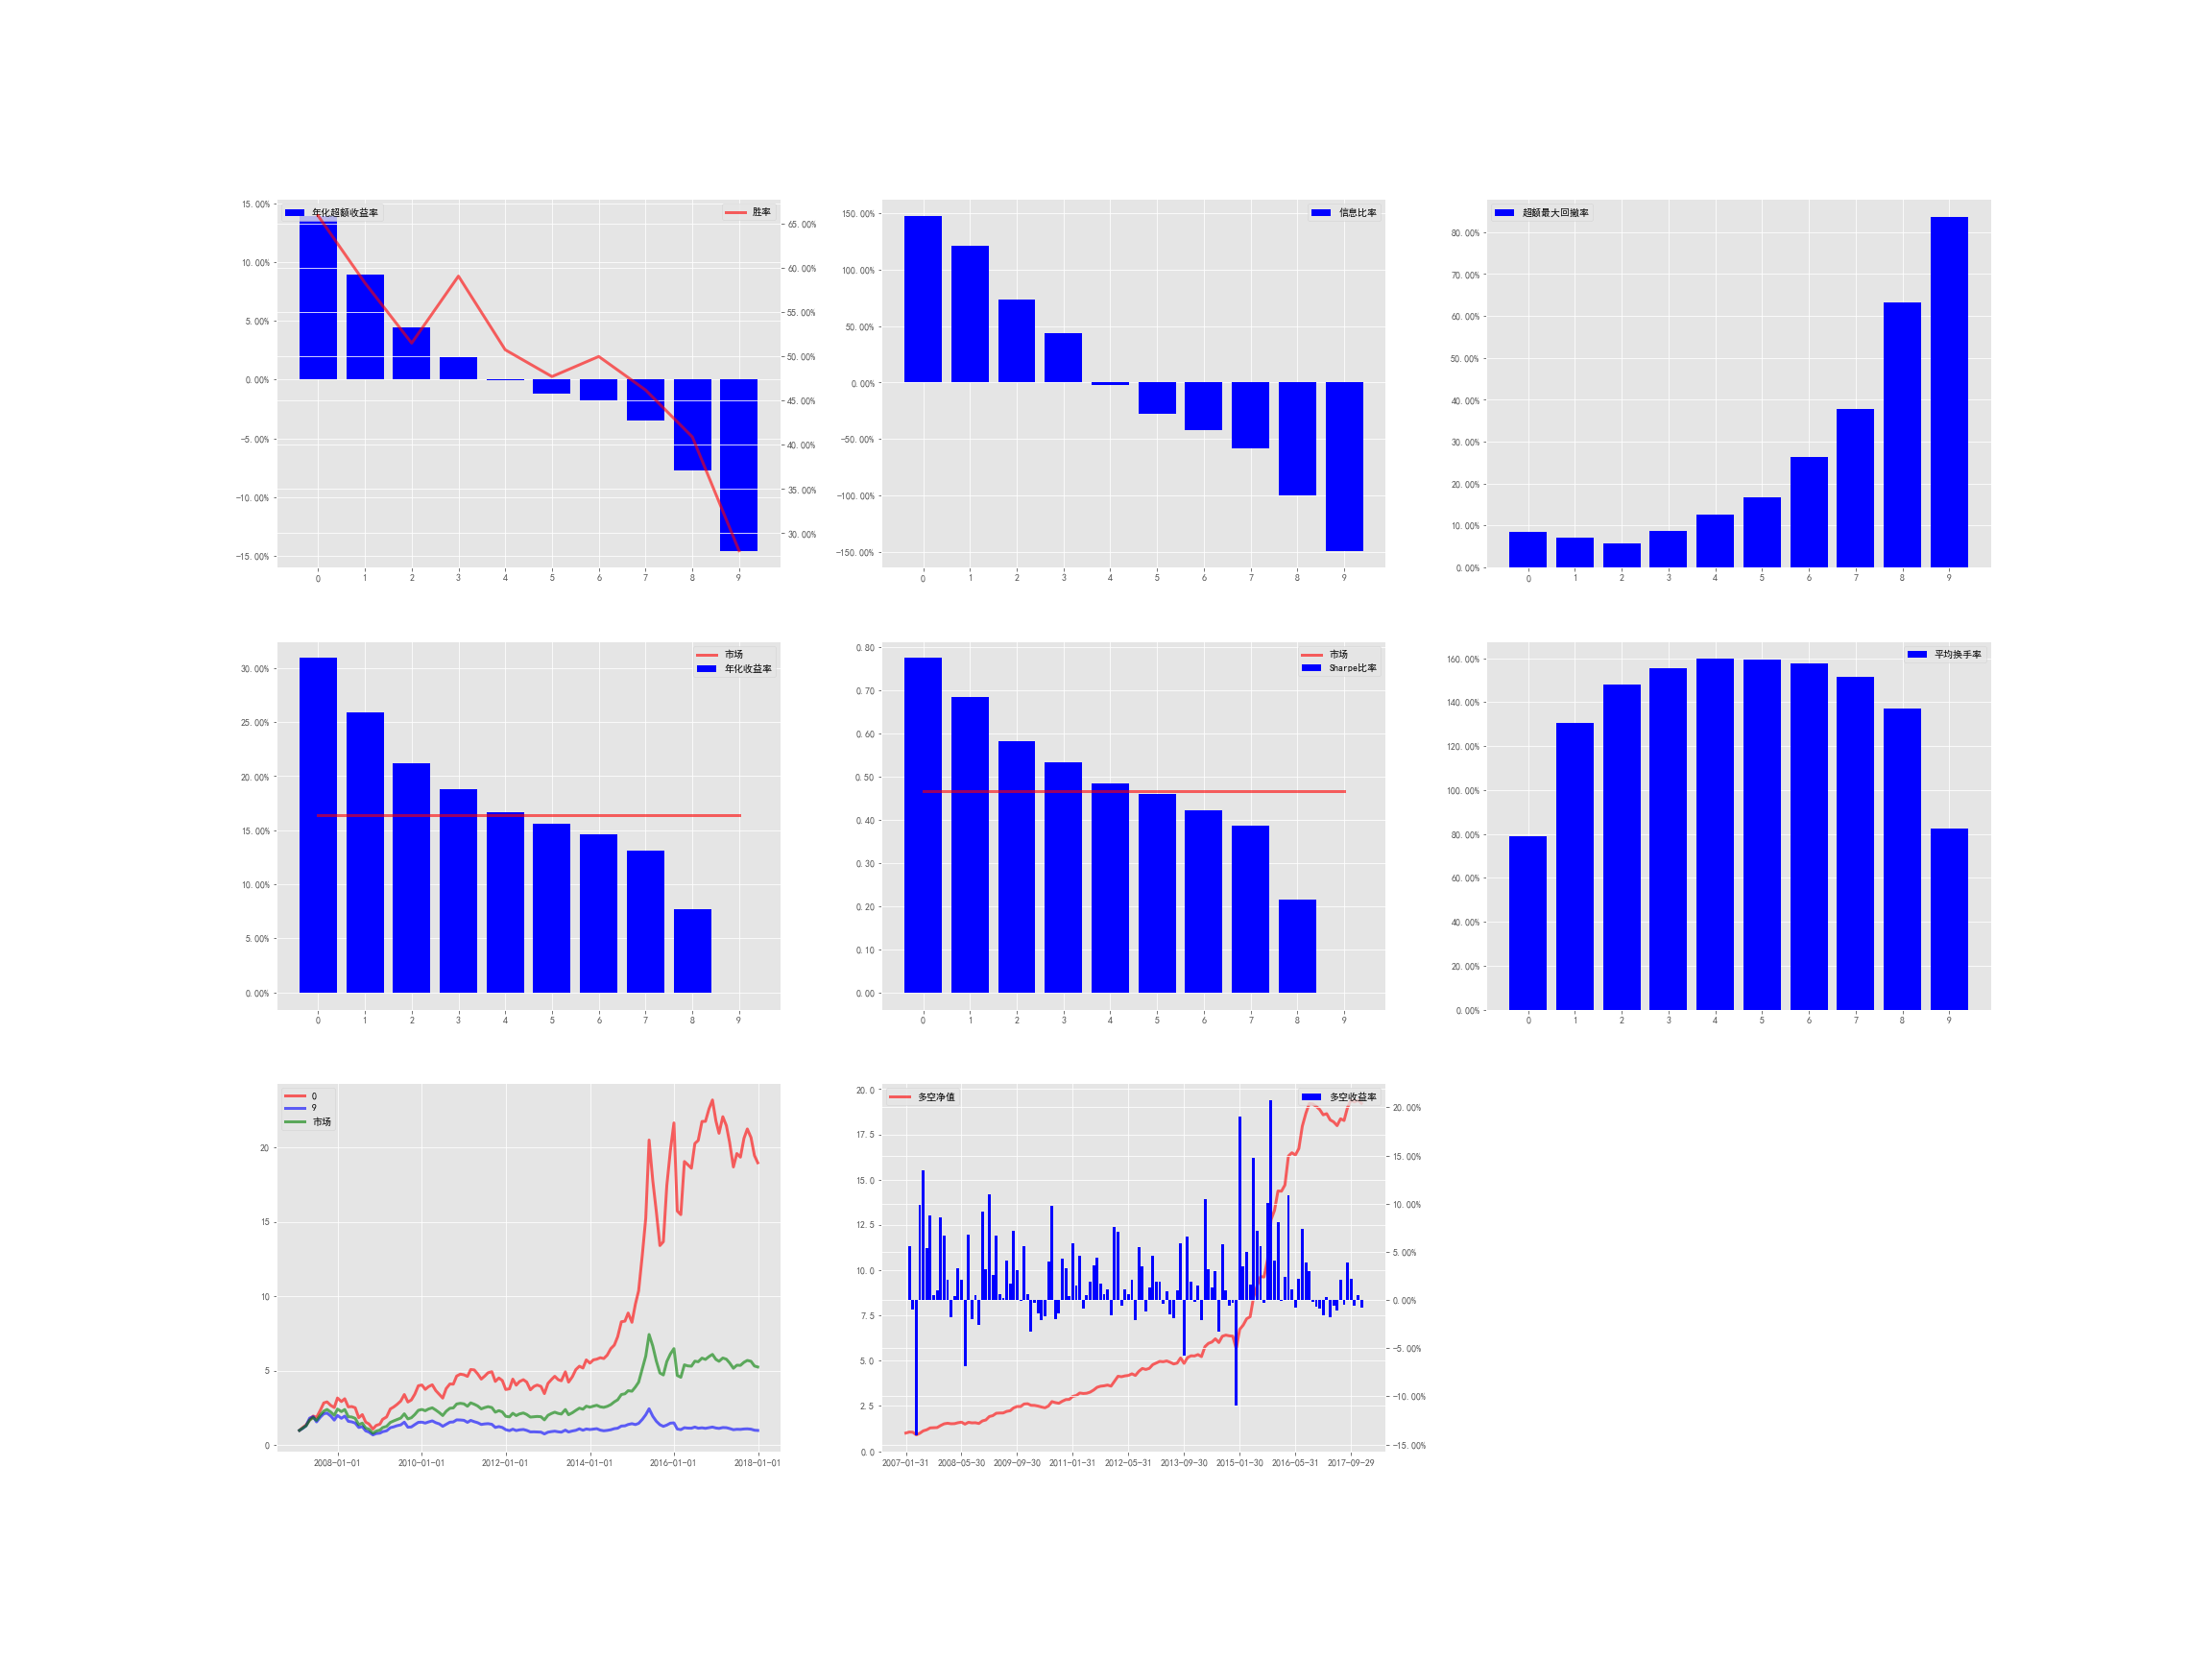

In [2]:
if __name__=='__main__':
    import matplotlib
    matplotlib.pyplot.ioff()
    import QuantStudio.api as QS
    
    # 创建因子库
    HDB = QS.FactorDB.HDF5DB()
    HDB.connect()
    
    # 创建自定义因子表
    MainFT = QS.FactorDB.CustomFT("MainFT")
    ElementaryFT = HDB.getTable("ElementaryFactor")
    DTs = ElementaryFT.getDateTime(ifactor_name="复权收盘价", start_dt=dt.datetime(2007, 1, 1), end_dt=dt.datetime(2018, 1, 1))
    MonthLastDTs = QS.Tools.DateTime.getMonthLastDateTime(DTs)
    FactorNames = FactorInfo.index.tolist()
    MainFT.addFactors(factor_table=ElementaryFT, factor_names=["复权收盘价", "中信行业", "是否在市"], args={})
    MainFT.addFactors(factor_table=HDB.getTable("StyleSentimentFactor"), factor_names=FactorNames, args={})
    MainFT.setDateTime(MonthLastDTs)
    MainFT.setID(ElementaryFT.getID(ifactor_name="复权收盘价"))
    
    # 创建回测模型
    Model = QS.BackTest.BackTestModel()
    # --------因子测试模块--------
    # IC 测试
    iModule = QS.BackTest.SectionFactor.IC(factor_table=MainFT)
    iModule["测试因子"] = FactorNames
    iModule["排序方向"] = FactorInfo["排序方向"].loc[FactorNames].to_dict()
    iModule["价格因子"] = "复权收盘价"
    iModule["计算时点"] = MonthLastDTs
    iModule["筛选条件"] = "@是否在市==1"
    Model.Modules.append(iModule)
    # 分位数组合测试
    for iFactorName in FactorNames:
        iModule = QS.BackTest.SectionFactor.QuantilePortfolio(factor_table=MainFT)
        iModule["测试因子"] = iFactorName
        iModule["排序方向"] = FactorInfo.loc[iFactorName, "排序方向"]
        iModule["价格因子"] = "复权收盘价"
        iModule["调仓时点"] = MonthLastDTs
        iModule["筛选条件"] = "@是否在市==1"
        Model.Modules.append(iModule)
    
    # 运行模型
    TestDateTimes = MainFT.getDateTime()
    Model.run(dts=TestDateTimes)
    
    display(Model)